*Antonio Coín Castro*     


# Bayesian Functional Logistic Regression

In [1]:
# -- Libraries
import sys
sys.path.append("bfr/")

import bayesian_model
from mle import compute_mle
import plot_utils
import simulation
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import utils
from multiprocessing import Pool
import scipy
import pickle
from sklearn_utils import PLSRegressionWrapper
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.utils.validation import check_is_fitted
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.exceptions import ConvergenceWarning
import preprocessing
from sklearn.model_selection import (
    train_test_split, StratifiedKFold
)
import warnings
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.ml.classification import (
    MaximumDepthClassifier, KNeighborsClassifier,
    NearestCentroid,
)
from skfda.preprocessing.smoothing.kernel_smoothers import (
    NadarayaWatsonSmoother as NW
)
from skfda.preprocessing.smoothing.validation import (
    SmoothingParameterSearch,
    LinearSmootherGeneralizedCVScorer,
    akaike_information_criterion
)
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FDataBasis, Fourier, BSpline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from _optimal_bayes import NaiveGPClassifier
from _fpca_basis import FPCABasis
from _fpls import FPLS, APLS, FPLSBasis
from _lda import LDA
import os
from skfda.preprocessing.dim_reduction.variable_selection import (
    RKHSVariableSelection as RKVS,
    RecursiveMaximaHunting as RMH,
    MinimumRedundancyMaximumRelevance as mRMR,
)
import skfda
import logging
from itertools import product
from IPython.display import display
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt

/tmp/tmpmwacl5gu/source.c:1:10: error fatal: cblas.h: No existe el fichero o el directorio
    1 | #include <cblas.h>
      |          ^~~~~~~~~
compilación terminada.


In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the binary $\{0,1\}$-model

$$
\mathbb P(Y=1\mid X=x) = \frac{1}{1 + \exp\{-\alpha_0-\Psi^{-1}_{x}(\alpha)\}},
$$

i.e., each $Y_i$ can be seen as a Bernoulli random variable $\mathcal B(p(x_i))$ with

$$
p(x_i)\equiv p_i=\mathbb P(Y_i=1\mid X_i=x_i) = \frac{1}{1 + \exp\left\{-\alpha_0-\displaystyle\sum_{j=1}^p \beta_jx_i(\tau_j)\right\}}.
$$

Note that $\mathbb E[Y_i]=p_i$ and $\operatorname{Var}(Y_i)=p_i(1-p_i)$.

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)\right]^{-1}\right).
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log \sigma)$, the joint log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \sum_{i=1}^n \left[ \left(\alpha_0 + \Psi^{-1}_{x_i}(\alpha)\right)y_i - \log\left(1 + \exp\left\{\alpha_0 + \Psi_{x_i}^{-1}(\alpha)\right\}\right)\right] +
\frac{1}{2}\log |G_\tau| - p\log \sigma -\frac{1}{2g\sigma^2} (\beta - b_0)'G_\tau(\beta - b_0).  
$$

The metrics considered for model evaluation will be:

- Accuracy.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, and a value of $\alpha_0=-0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 + 5X_i(0.1) - 10X_i(0.8)\right\}}\right)
$$

or

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 -\int_0^1 \beta(t)X_i(t)\, dt\right\}}\right),
$$

where $\beta(t) \in L^2[0, 1]$.

Another possibility is to generate a dataset from two different Gaussian processes, and label them according to the (known) distribution of $X^{(j)}$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2', 'RKHS' or 'MIXTURE'
REAL_DATA = "Growth"
NOISE = 0.1

INITIAL_SMOOTHING = "NW"  # None, NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False

kernel_fn = simulation.fractional_brownian_kernel
kernel_fn2 = simulation.squared_exponential_kernel
basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    mean_vector = None
    mean_vector2 = np.ones(N)
    alpha0_true = -0.5

    if MODEL_GEN == "MIXTURE":
        x, y = utils.generate_classification_dataset(
            grid, kernel_fn, kernel_fn2,
            n_train + n_test, rng,
            mean_vector, mean_vector2)
    else:
        if MODEL_GEN == "L2":
            x, y_lin = simulation.generate_gp_l2_dataset(
                grid, kernel_fn,
                n_train + n_test, beta_coef,
                alpha0_true, 0.0, rng=rng
            )
        elif MODEL_GEN == "RKHS":
            beta_true = np.array([-5., 10.])
            tau_true = np.array([0.1, 0.8])
            x, y_lin = simulation.generate_gp_rkhs_dataset(
                grid, kernel_fn,
                n_train + n_test, beta_true, tau_true,
                alpha0_true, 0.0, rng=rng
            )
        else:
            raise ValueError("Invalid model generation strategy.")

        # Transform linear response for logistic model
        y = bayesian_model.probability_to_label(
            y_lin, random_noise=NOISE, rng=rng)

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x,
        y,
        train_size=n_train,
        stratify=y,
        random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Medflies":
        x, y = skfda.datasets.fetch_medflies(return_X_y=True)
    elif REAL_DATA == "Growth":
        x, y = skfda.datasets.fetch_growth(return_X_y=True)
    else:
        raise ValueError("REAL_DATA must be 'Medflies' or 'Growth'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.8, stratify=y, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = grid = preprocessing.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)


# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

Smoother: NadarayaWatsonSmoother
Smoothing parameter: 0.013


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:953: UserWarning:One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan -0.001 -0.001 -0.001
 -0.001 -0.001 -0.    -0.    -0.001 -0.001 -0.001 -0.002 -0.003 -0.007
 -0.013 -0.026 -0.048 -0.071 -0.088 -0.098 -0.103 -0.105 -0.106 -0.107
 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107
 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107]


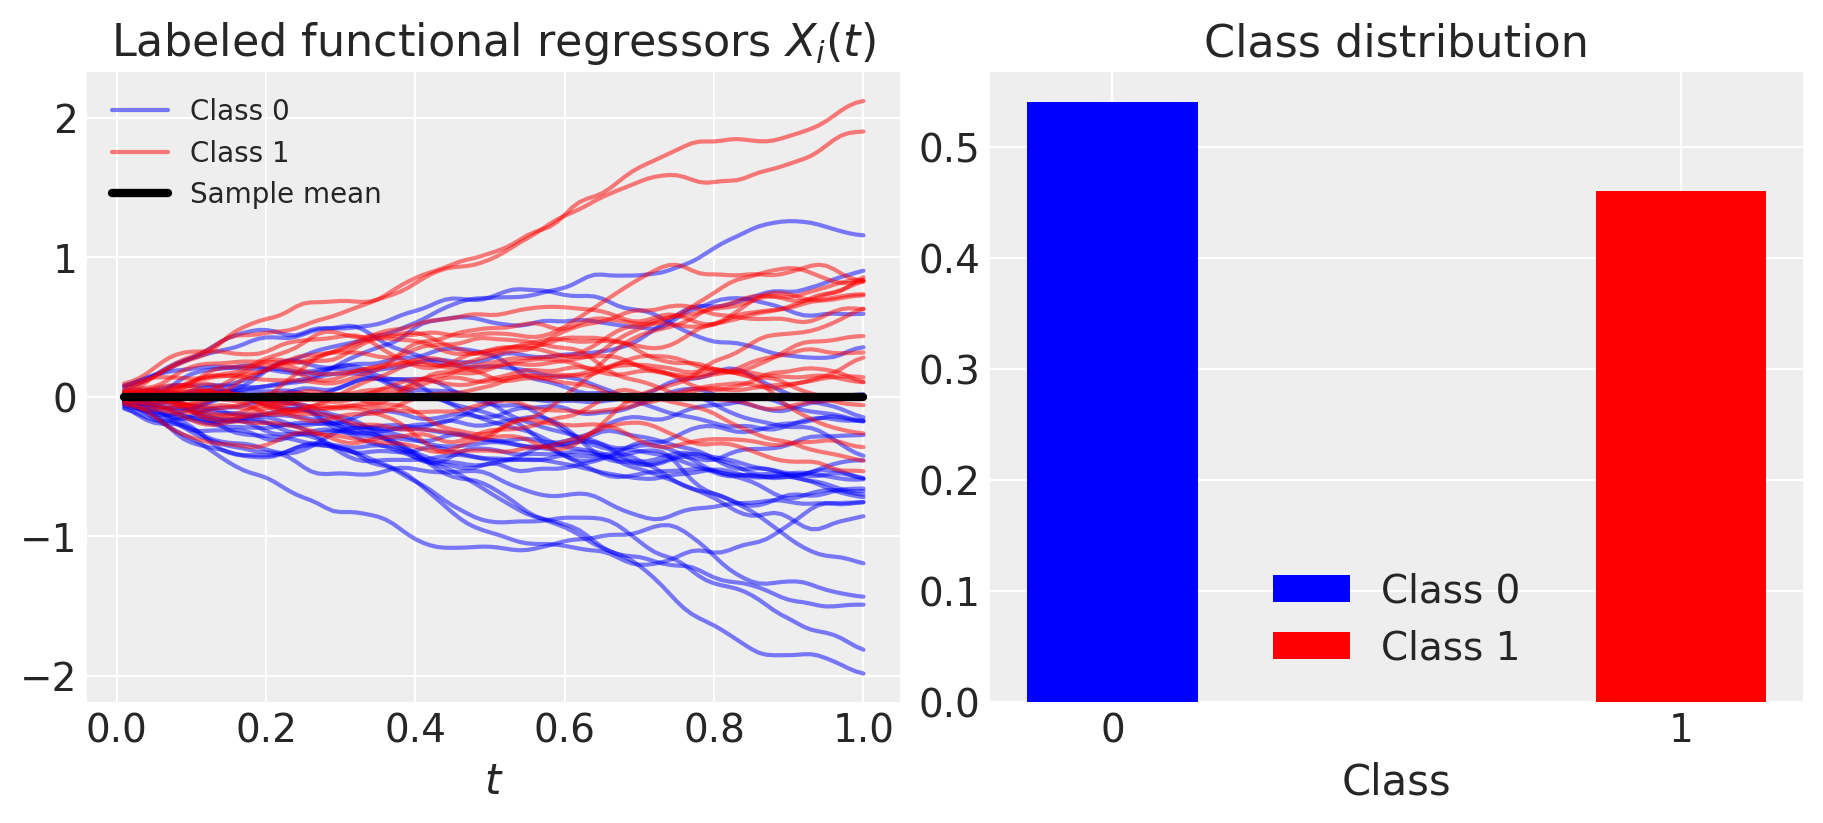

In [10]:
# -- Dataset visualization

if SYNTHETIC_DATA:
    n_samples = n_train//2
elif REAL_DATA == "Medflies":
    n_samples = n_train//5
else:
    n_samples = n_train

plot_utils.plot_dataset_classification(
    X,
    Y,
    n_samples=n_samples
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [5]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.1

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.10,
    2: 0.60,
    3: 0.30,
}

beta_range = (-500, 500)

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = False
COMPUTE_MLE = True

In [6]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [7]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = StratifiedKFold(shuffle=True, random_state=SEED)

## Sklearn model comparison

In [8]:
# -- Select family of classifiers

Cs = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
n_neighbors = [3, 5, 7]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

basis_fpls = []
for p in n_components:
    try:
        basis_fpls.append(FPLSBasis(X_fd, Y, n_basis=p))
    except ValueError:
        print(f"Can't create FPLSBasis with n_basis={p}")
        continue

ridge_regressors = [Ridge(alpha=C) for C in Cs]
lasso_regressors = [Lasso(alpha=C) for C in Cs]
pls_regressors = [PLSRegressionWrapper(n_components=p) for p in n_components]
fpls_regressors = [FPLS(n_components=p) for p in n_components]
apls_regressors = [APLS(n_components=p) for p in n_components]


params_clf = {"clf__C": Cs}
params_svm = {"clf__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_var_sel = {"var_sel__n_features_to_select": n_components}
params_knn = {"clf__n_neighbors": n_neighbors,
              "clf__weights": ['uniform', 'distance']}
params_depth = {"clf__depth_method": [ModifiedBandDepth(), IntegratedDepth()]}
params_mrmr = {"var_sel__method": ["MID", "MIQ"]}
params_base_regressors_ridge = {"clf__base_regressor": ridge_regressors}
params_base_regressors_lasso = {"clf__base_regressor": lasso_regressors}
params_base_regressors_pls = {"clf__base_regressor": pls_regressors}
params_base_regressors_fpls = {"clf__base_regressor": fpls_regressors}
params_base_regressors_apls = {"clf__base_regressor": apls_regressors}

classifiers = utils.logistic_regression_comparison_suite(
    params_clf,
    params_base_regressors_ridge,
    params_base_regressors_lasso,
    params_base_regressors_pls,
    params_base_regressors_fpls,
    params_base_regressors_apls,
    params_select,
    params_dim_red,
    params_var_sel,
    params_svm,
    params_depth,
    params_knn,
    params_basis,
    random_state=SEED,
)

In [9]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, clf_cv = utils.cv_sk(
        classifiers,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='logistic',
        n_jobs=N_CORES,
        verbose=True,
    )
    display(df_metrics_sk.style.hide(axis="index"))

## Maximum Likelihood Estimator

In [10]:
# -- MLE computation

if True:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='logistic',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_logistic(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Classification metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 135.052


Classification metrics:


## The Ensemble Sampler and the *emcee* library

In [11]:
import emcee
from mcmc_sampler import BFLogisticEmcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [12]:
# -- Sampler parameters

n_walkers = 64
n_iter_warmup = 100
n_iter = 1000

compute_pp = True
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [13]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

clf_emcee = BFLogisticEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=SEED,  # change to 'rng' for different outputs each time
)

if FAST_RUN:
    df_metrics_emcee = utils.run_bayesian_model(
        clf_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='logistic',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=-1,
        random_state=SEED,
    )
    if COMPUTE_MLE:
        df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
    if FIT_SK:
        df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

    df_metrics_emcee.sort_values(
        df_metrics_emcee.columns[-1],
        inplace=True,
        ascending=False
    )
    display(df_metrics_emcee.style.hide(axis="index"))
else:
    clf_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*clf_emcee.mean_acceptance():.3f}%")

idata_emcee = clf_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BRKHSFReg] Computing MLE...
[BRKHSFReg] MCMC warmup iterations...


[BRKHSFReg] MCMC:   0%|          | 0/1000 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [82.432 84.476 82.493 78.359 70.939 86.862 80.178 63.858]


[BRKHSFReg] Discarding the first 100 samples...
Mean acceptance: 19.103%


mean        sd  hdi_3%   hdi_97%     min         max  median  \
β[1]        -17.558     7.597 -25.920     4.837 -40.826      15.515 -19.961   
β[2]          7.905     4.780  -1.835    16.817 -18.840      28.141   9.109   
β[3]          2.014     1.686   0.785     7.211  -6.917      13.473   1.855   
τ[1]          0.108     0.183   0.000     0.559   0.000       0.853   0.036   
τ[2]          0.168     0.177   0.000     0.569   0.000       0.983   0.103   
τ[3]          0.833     0.139   0.573     1.000   0.153       1.000   0.869   
$\alpha_0$   -0.074     0.300  -0.599     0.442  -1.250       1.163  -0.082   
$\sigma^2$  364.413  2327.603   0.013  1018.921   0.006  122096.424  10.743   

               mode  
β[1]        -20.413  
β[2]         10.018  
β[3]          1.784  
τ[1]          0.043  
τ[2]          0.099  
τ[3]          0.925  
$\alpha_0$    0.029  
$\sigma^2$  119.241


Computing metrics...

Generating posterior predictive samples...
Generating posterior predictive samples...


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [14]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = clf_emcee.total_samples()

# Get autocorrelation times
autocorr = clf_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 18;
tau: [73.62  75.931 75.02  70.659 65.032 80.731 74.791 56.643]


In [15]:
# -- Trace summary

clf_emcee.summary()

mean        sd  hdi_3%   hdi_97%     min         max  median  \
β[1]        -17.558     7.597 -25.920     4.837 -40.826      15.515 -19.961   
β[2]          7.905     4.780  -1.835    16.817 -18.840      28.141   9.109   
β[3]          2.014     1.686   0.785     7.211  -6.917      13.473   1.855   
τ[1]          0.108     0.183   0.000     0.559   0.000       0.853   0.036   
τ[2]          0.168     0.177   0.000     0.569   0.000       0.983   0.103   
τ[3]          0.833     0.139   0.573     1.000   0.153       1.000   0.869   
$\alpha_0$   -0.074     0.300  -0.599     0.442  -1.250       1.163  -0.082   
$\sigma^2$  364.413  2327.603   0.013  1018.921   0.006  122096.424  10.743   

               mode  
β[1]        -20.413  
β[2]         10.018  
β[3]          1.784  
τ[1]          0.043  
τ[2]          0.099  
τ[3]          0.925  
$\alpha_0$    0.029  
$\sigma^2$  119.241

Combined density and trace plot:


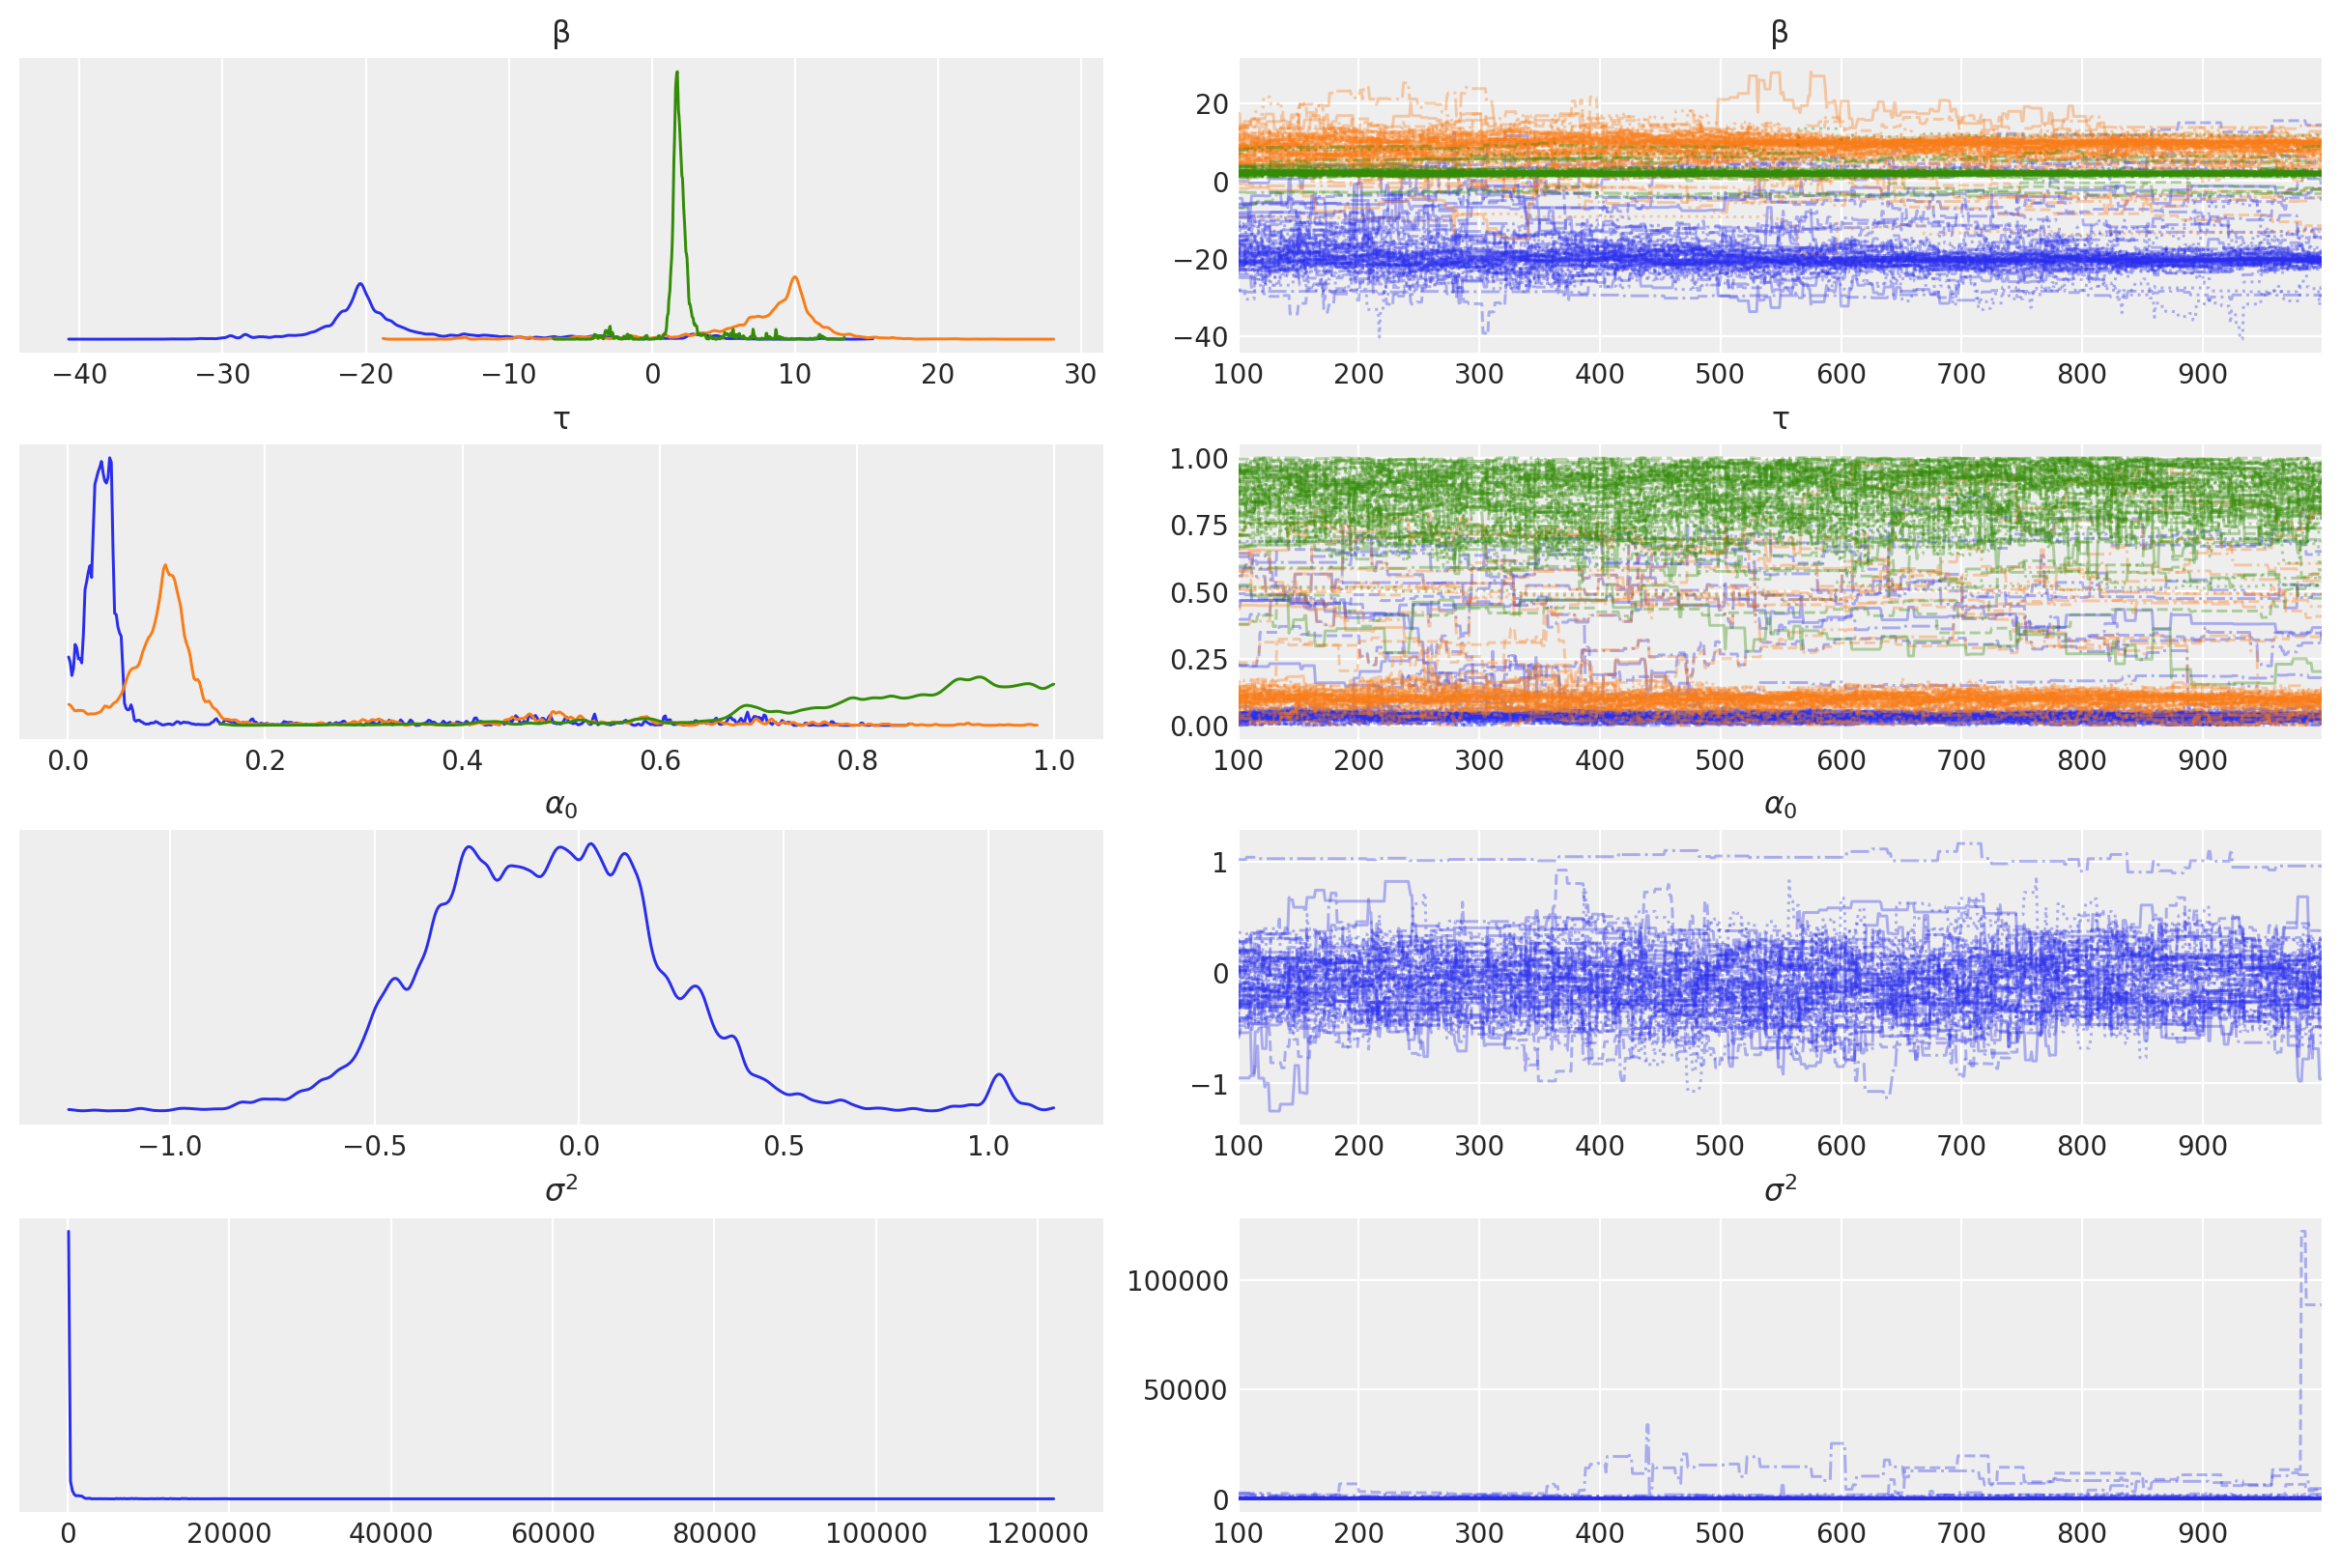

In [16]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


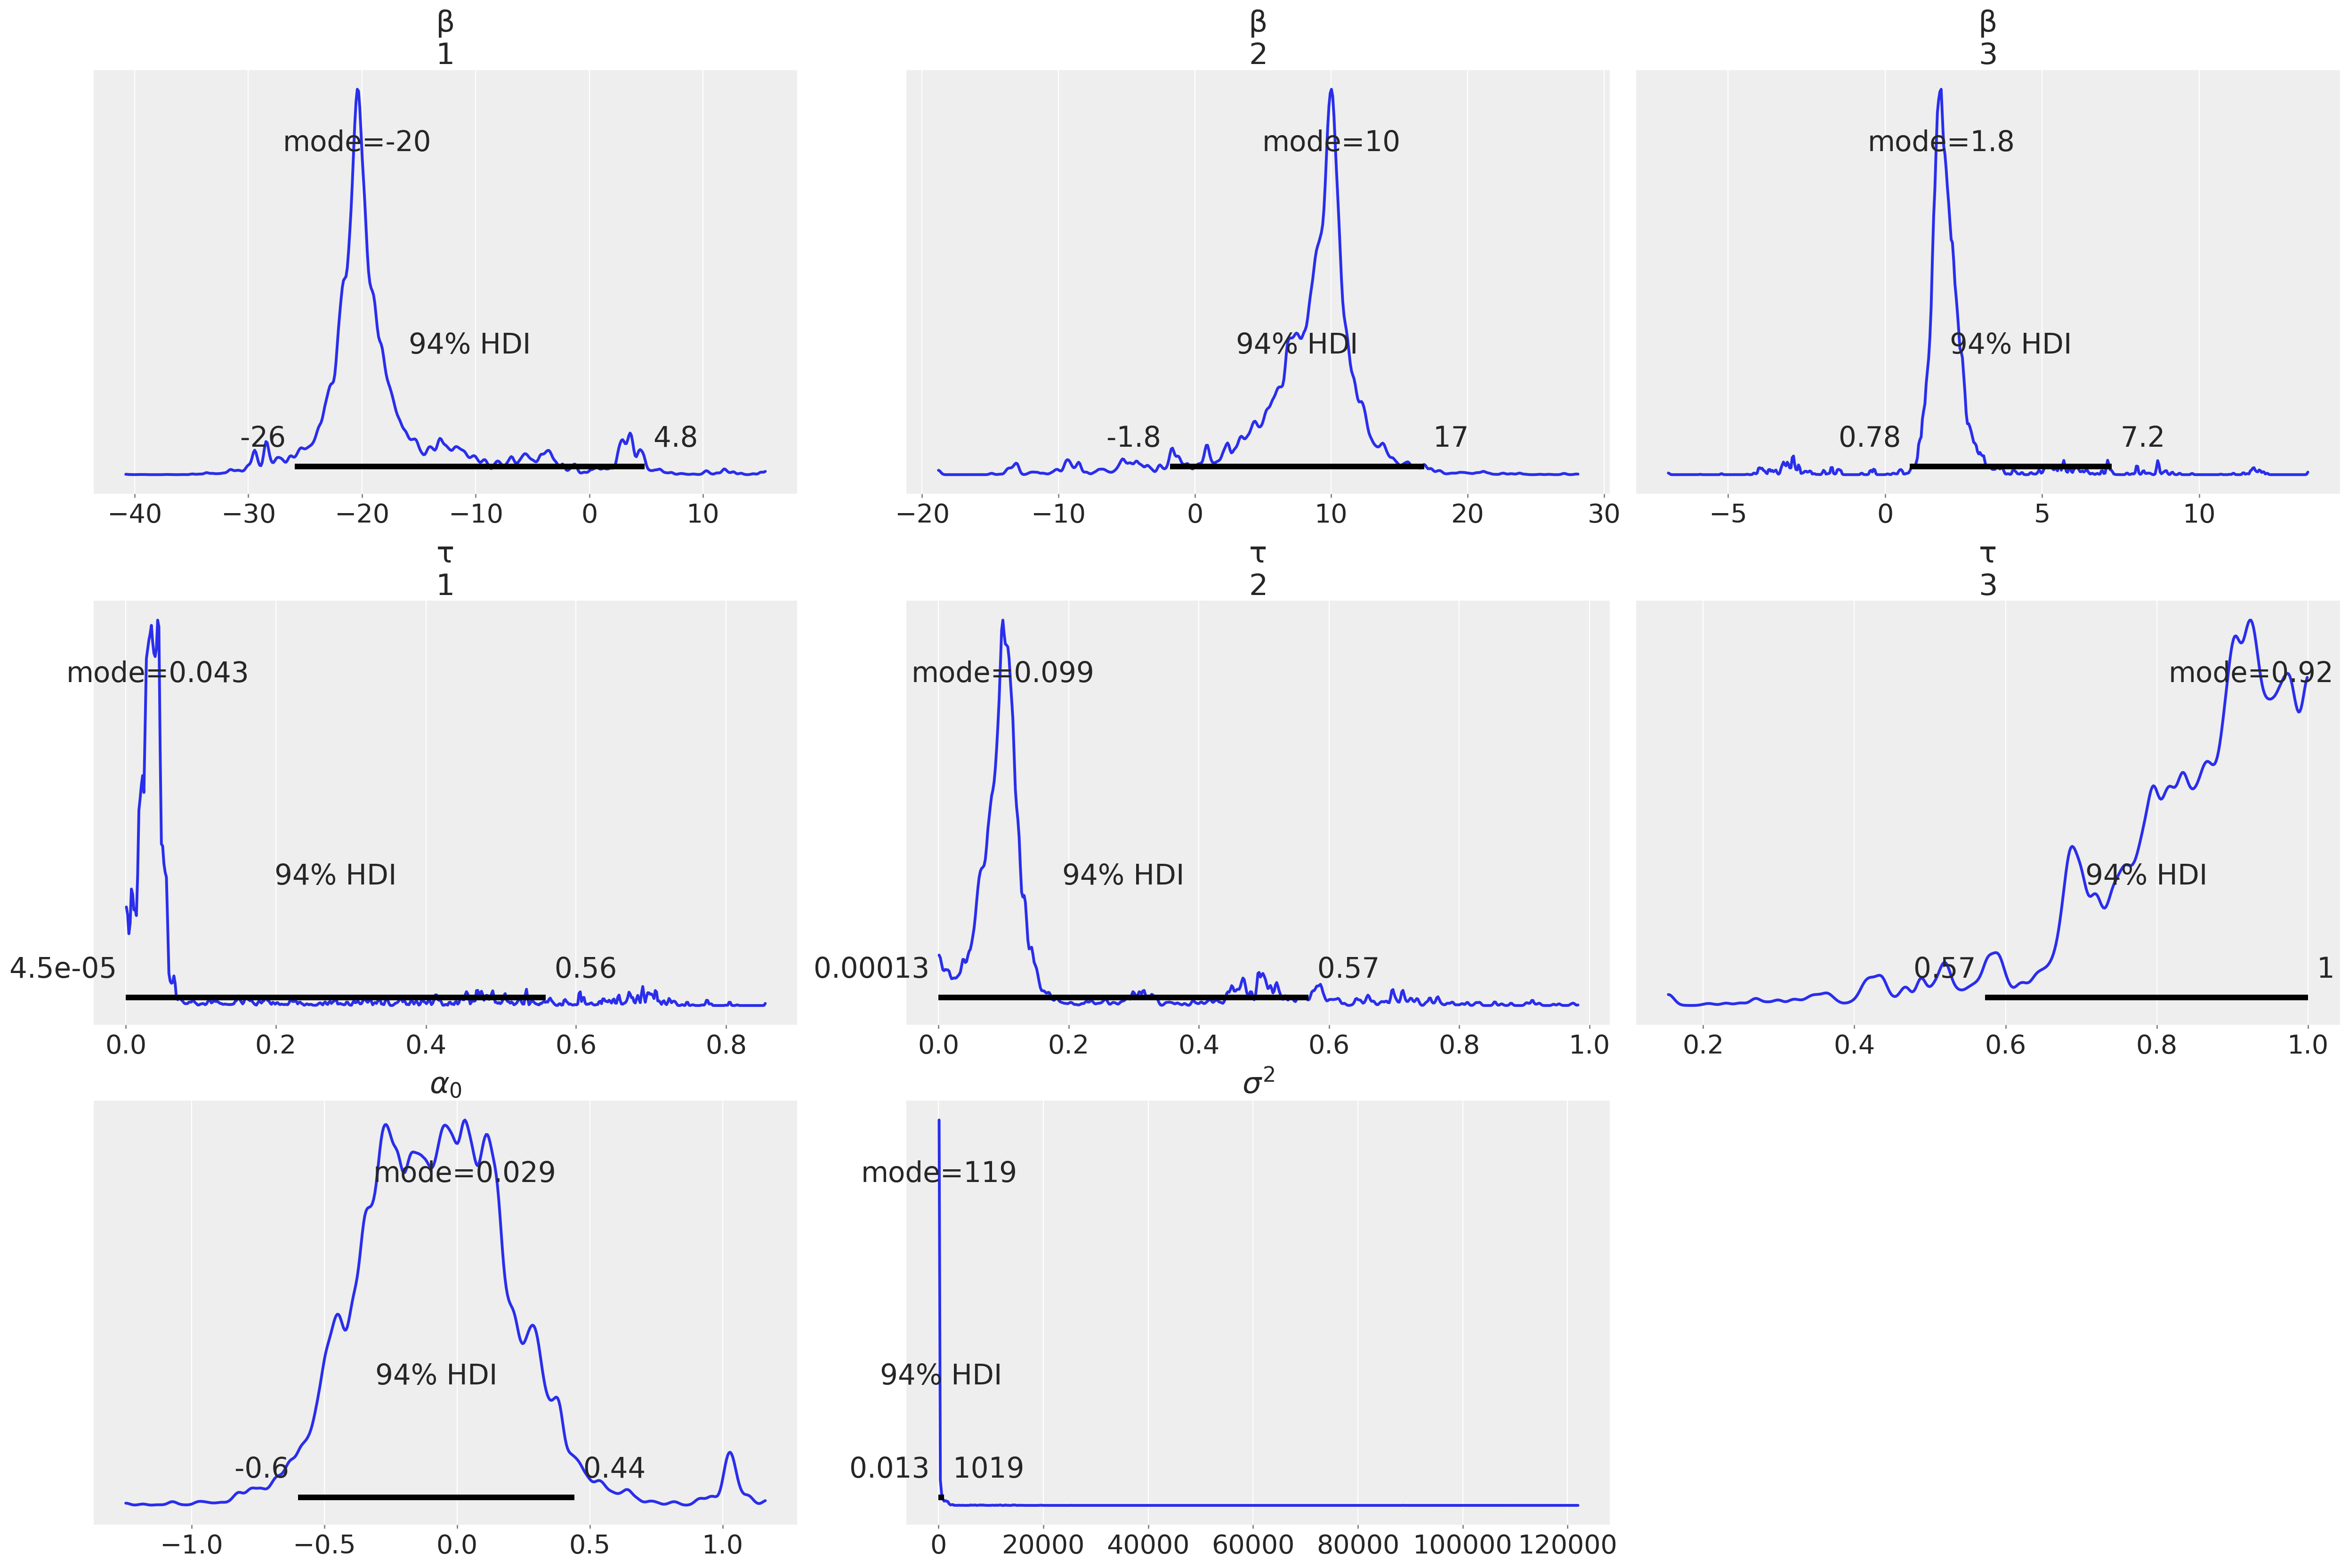

In [18]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

In this case, since the outcome variable is binary, we plot the distribution of $T(Y^*)$ to visually compare it with $T(Y)$, where $T$ is the number of $1$s in the sample (the number of successes). 

We also show a *separation plot*, in which the predicted probabilities $\hat p_i$ (suitably averaged for each chain and sample) are ordered in an ascending manner, and then a vertical line is drawn on each of them either in a dark color (if $y_i$ is 1) or a light color (if $y_i$ is 0). In a perfect model, all the dark lines would be on the rightmost part, effectively "separating" the samples.

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.346
bpv [T=mean]: 0.346
bpv [T=std]: 0.823


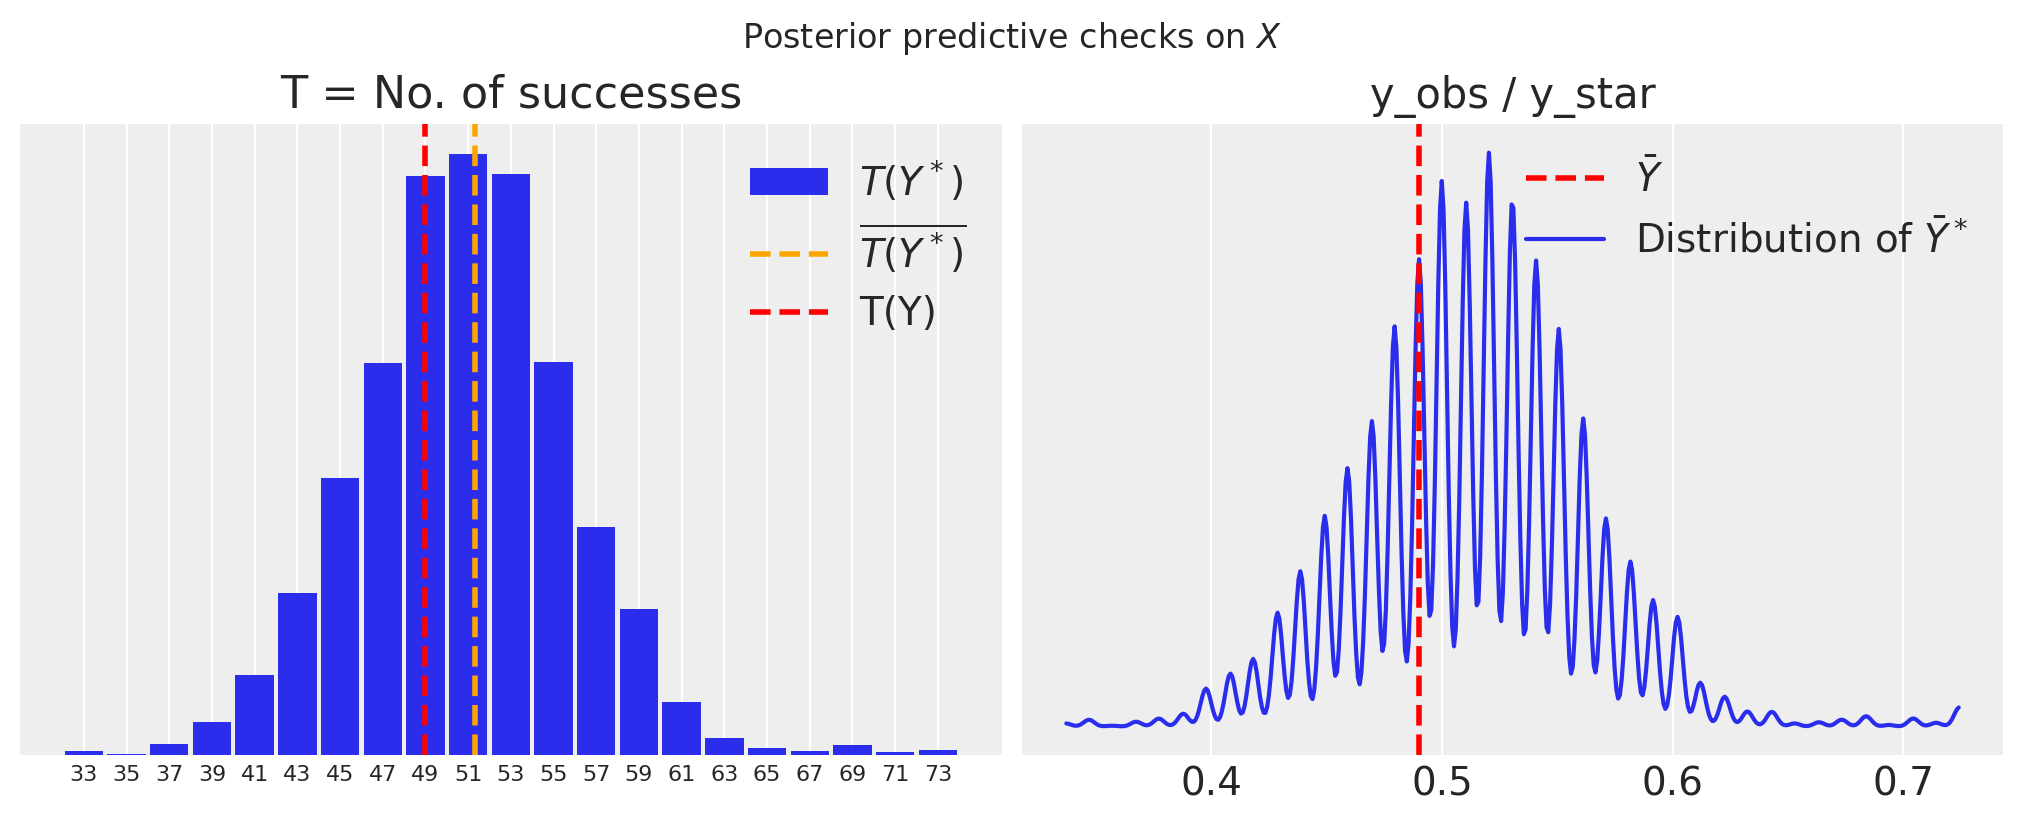

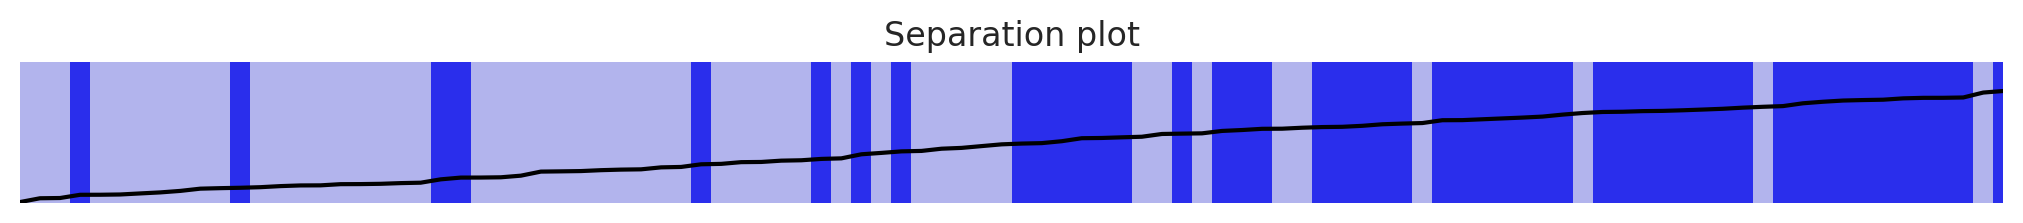

In [19]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp_p, pp_y = bayesian_model.generate_pp(
        idata_emcee, X, theta_space, 
        kind='logistic', rng=rng, verbose=True)
    utils.pp_to_idata([pp_p, pp_y], idata_emcee,
                      ["p_star", "y_star"], merge=True)
else:
    pp_p = idata_emcee.posterior_predictive['p_star'].to_numpy()
    pp_y = idata_emcee.posterior_predictive['y_star'].to_numpy().astype(int)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


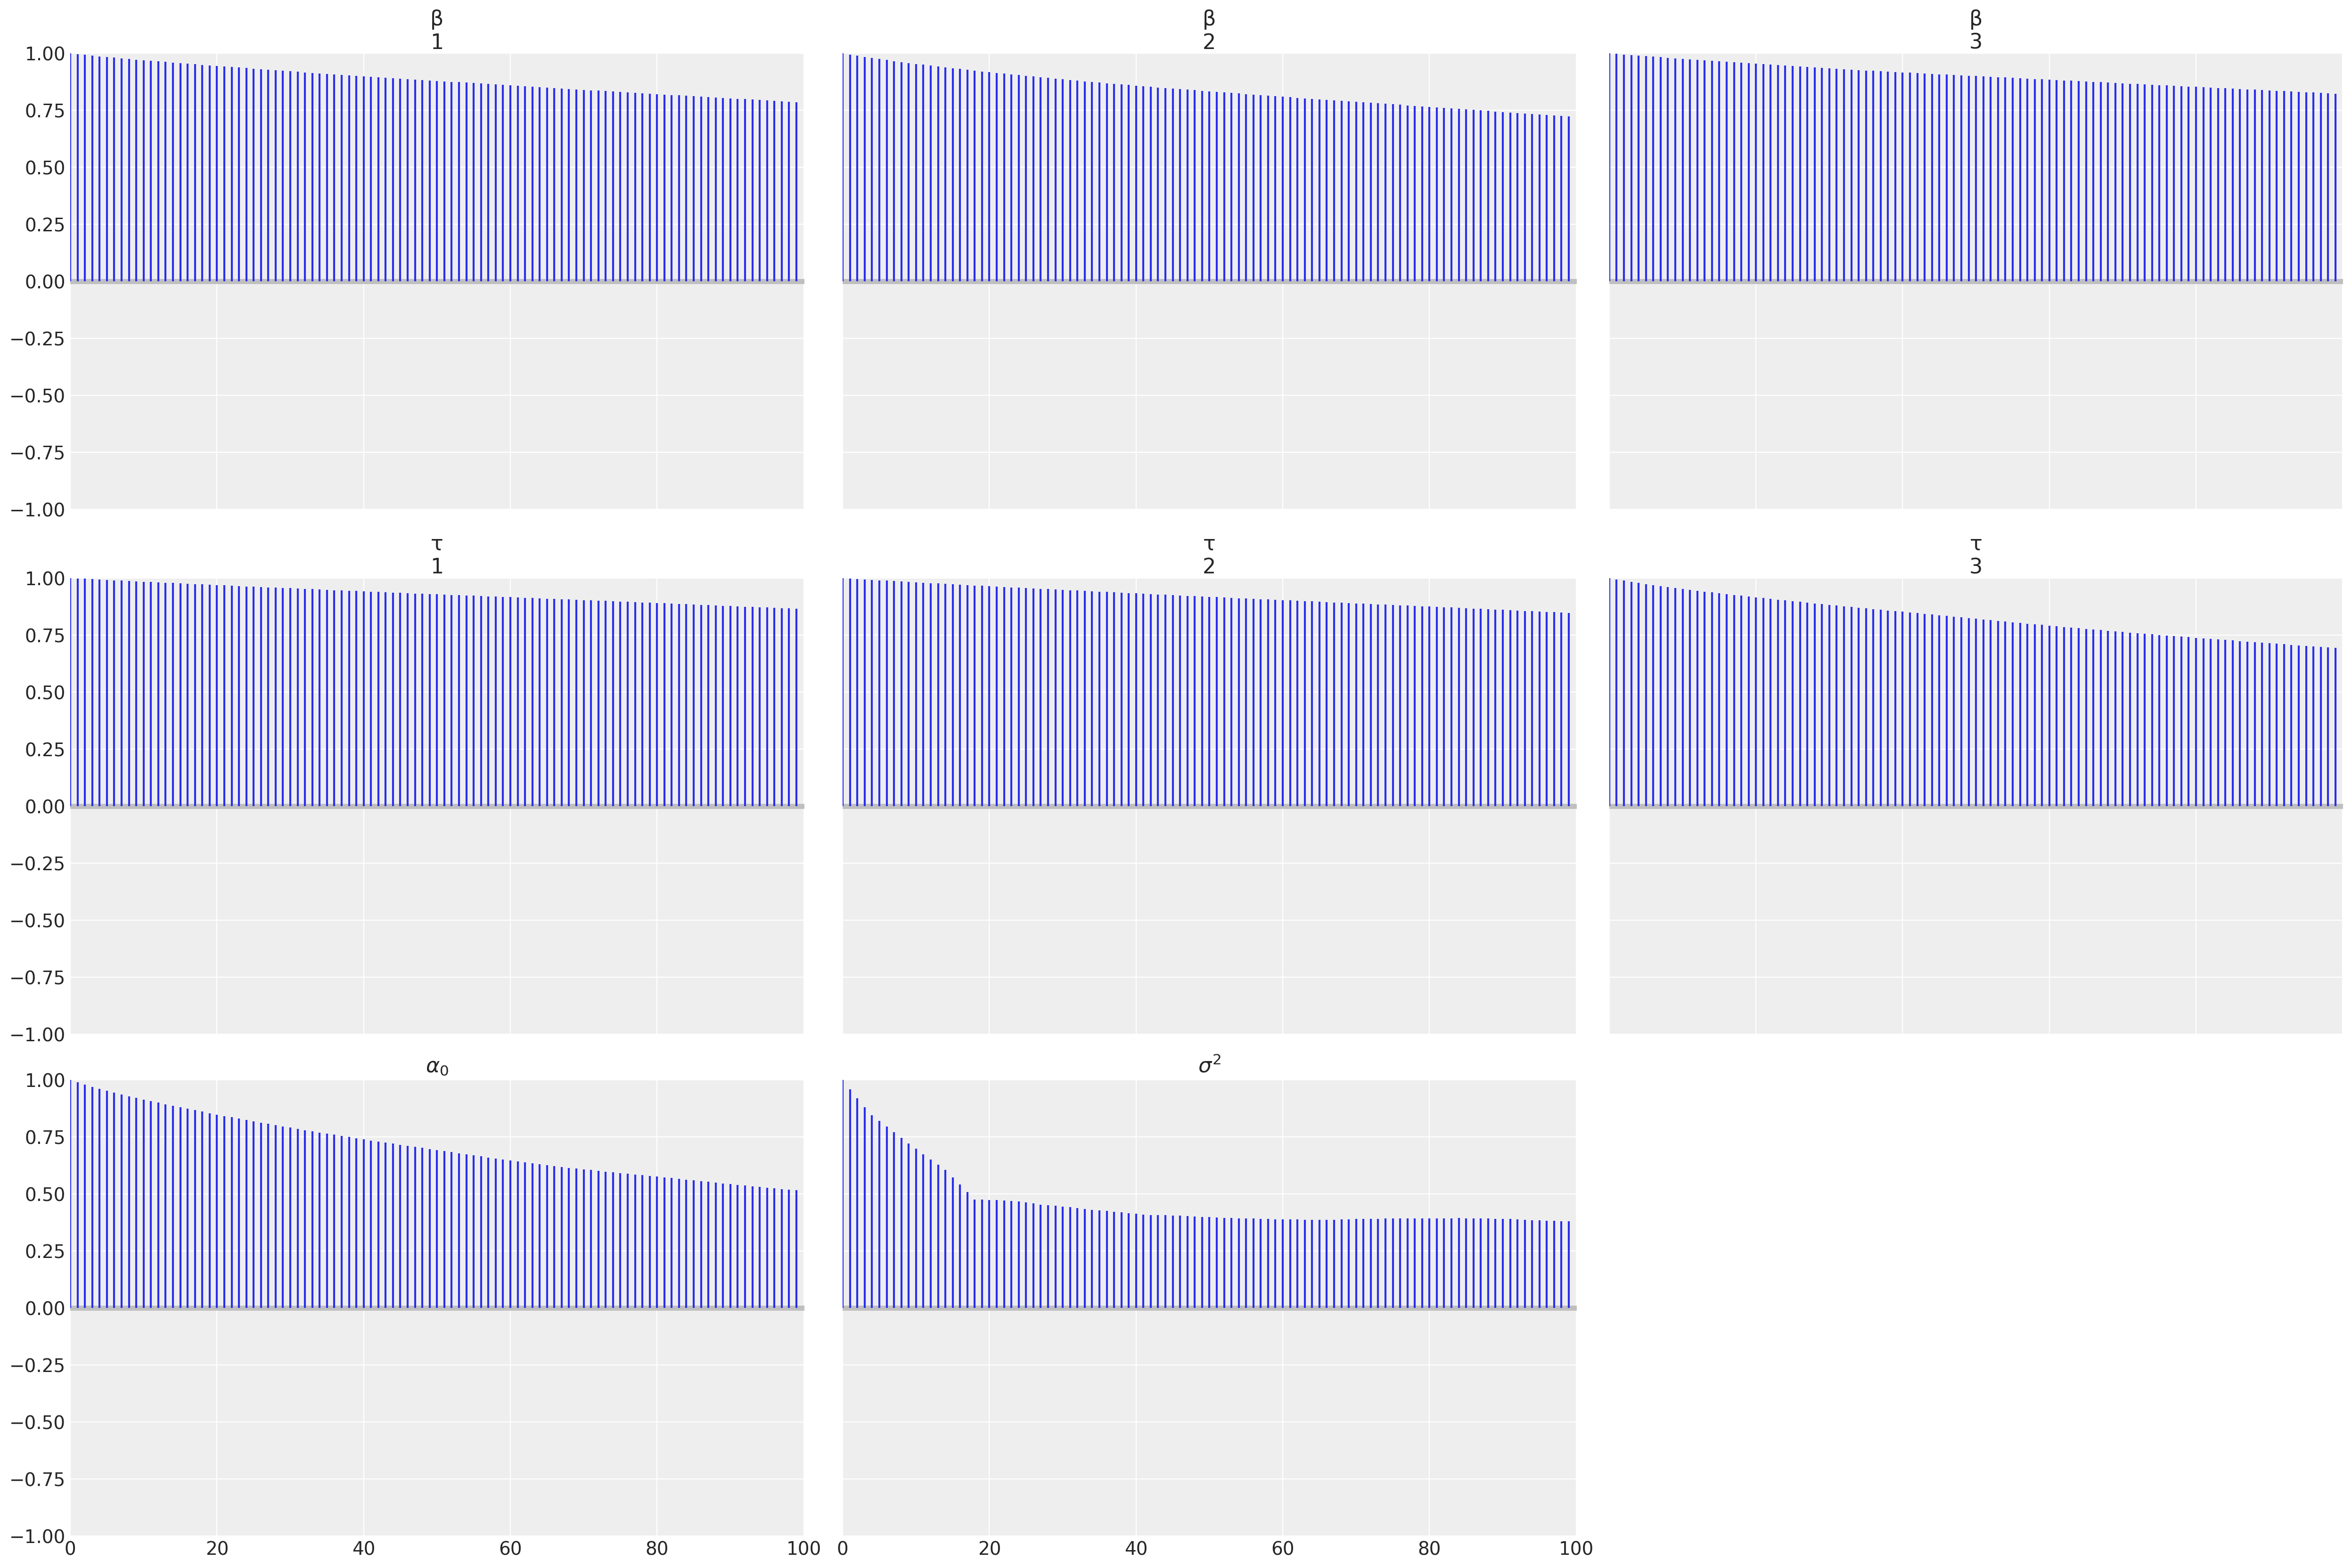

In [20]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.445
bpv [T=mean]: 0.445
bpv [T=std]: 1.000


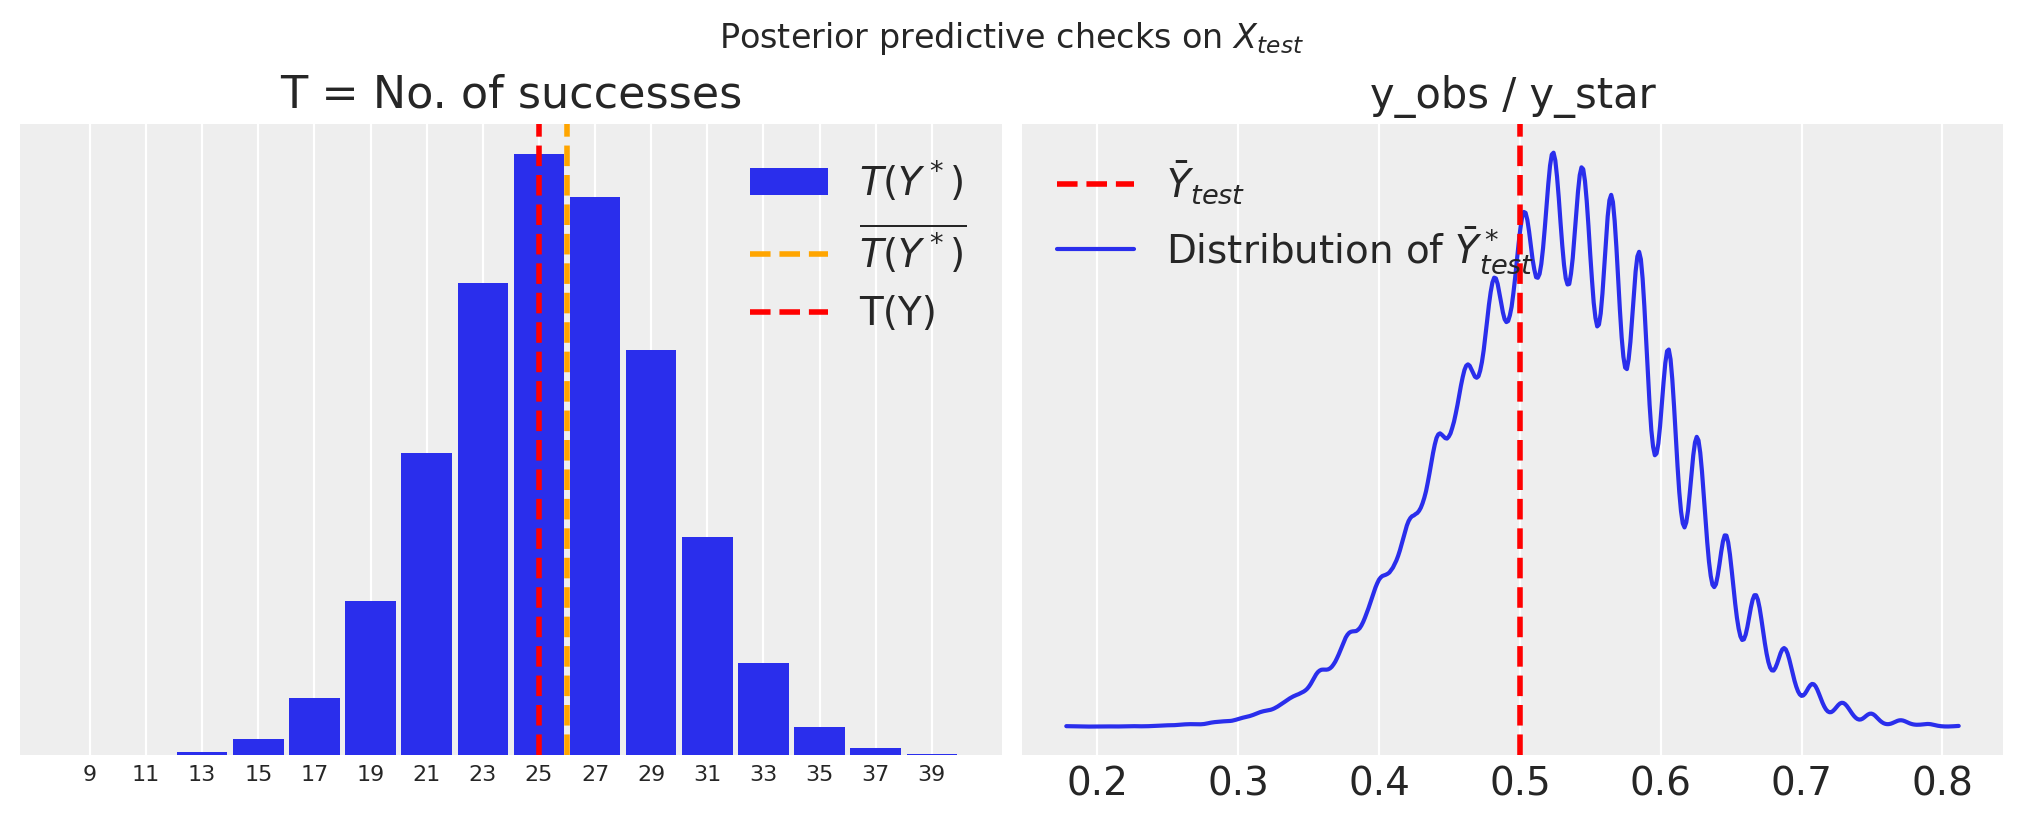

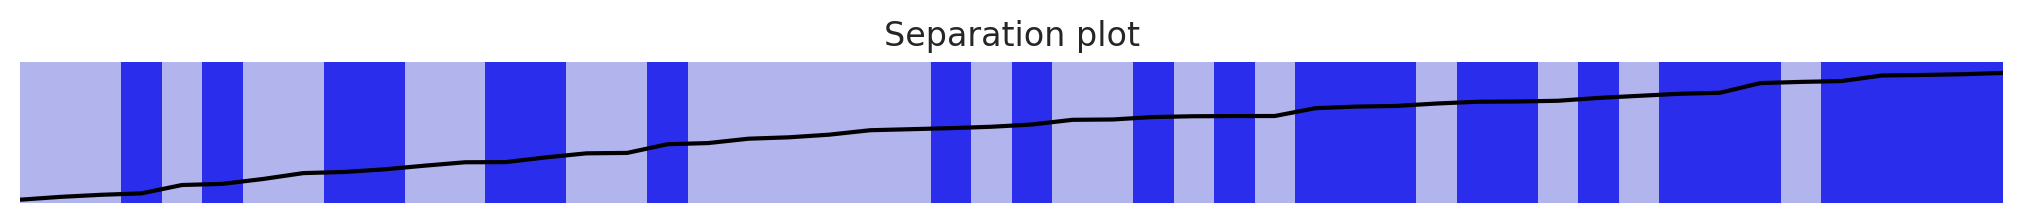

In [21]:
# -- Generate and plot posterior predictive samples from X_test

pp_test_p, pp_test_y = bayesian_model.generate_pp(
    idata_emcee, X_test, theta_space, rng=rng, 
    kind='logistic', verbose=True)
idata_pp_test = utils.pp_to_idata(
    [pp_test_p, pp_test_y], idata_emcee, ["p_star", "y_star"], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [22]:
# -- Compute metrics using several point estimates

df_metrics_emcee = None

# Posterior mean estimates
strategies = [("posterior_mean", pp_test_p), ("posterior_vote", pp_test_y)]
for name, pp in strategies:
    Y_pred_pp = [utils.threshold(y)
                 for y in pp[:, ::thin_pp, :].mean(axis=(0, 1))]
    df_metrics_emcee = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pp,
        clf_emcee.n_components(name),
        "emcee_" + name,
        df=df_metrics_emcee,
        sort_by=-1
    )

# Point estimates
for pe in clf_emcee.default_point_estimates:
    Y_pred_pe = clf_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pe,
        clf_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
        sort_by=-1,
    )

df_metrics_emcee.style.hide(axis="index")

In [23]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in clf_emcee.default_point_estimates:
    X_red = clf_emcee.transform(X, pe=pe)
    X_test_red = clf_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = utils.multiple_logistic_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [ ]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [ ]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [28]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

In [29]:
# -- Probabilistic model

def make_model(theta_space, g, eta, X, Y, names, names_aux, mle_theta=None):
    n, N = X.shape
    grid = theta_space.grid
    p = theta_space.p

    if mle_theta is not None:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        px = pm.Deterministic(
            'p_star',
            pm.math.invlogit(alpha0 + pm.math.matrix_dot(X_tau, beta)))

        y_obs = pm.Bernoulli('y_obs', p=px, observed=Y)

    return model

### Experiments

In [30]:
# -- Hyperparameters

burn = 0
thin = 1
thin_pp = 5

n_samples_nuts = 1000
tune_nuts = 1200
target_accept = 0.81
n_samples_metropolis = 10000
tune_metropolis = 3000

USE_NUTS = False

In [31]:
### NOTE: Sort_values ascending

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [τ]
>Metropolis: [α0 and log σ]


Sampling 2 chains for 3_000 tune and 10_000 draw iterations (6_000 + 20_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [32]:
utils.summary(idata_pymc, var_names=theta_names, labeller=theta_labeller)

mean        sd  hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
β[0]         -15.186    10.865 -28.207     4.182      6.153    4.838   
β[1]           6.591     4.330  -1.804    13.921      1.090    0.786   
β[2]          -0.207     5.922 -14.446    10.094      2.480    1.852   
τ[0]           0.126     0.208   0.000     0.584      0.072    0.053   
τ[1]           0.438     0.355   0.040     0.956      0.184    0.142   
τ[2]           0.666     0.321   0.031     0.993      0.095    0.077   
$\alpha_0$    -0.094     0.257  -0.550     0.418      0.005    0.003   
$\sigma^2$  1111.885  9108.506   0.003  2655.636    545.403  386.062   

            ess_bulk  ess_tail  r_hat     mode   median  
β[0]             4.0      33.0   1.56  -22.745  -21.324  
β[1]            18.0      30.0   1.23    9.074    8.206  
β[2]            11.0      29.0   1.44    1.711    1.724  
τ[0]             9.0      72.0   1.26    0.028    0.031  
τ[1]             5.0     144.0   1.30    0.102    0.317  
τ[2]            10.0      33.0   1.15    0.918    0.808  
$\alpha_0$    2983.0    4008.0   1.00   -0.065   -0.088  
$\sigma^2$       4.0      32.0   1.42  332.859  136.566

Density and trace plot:


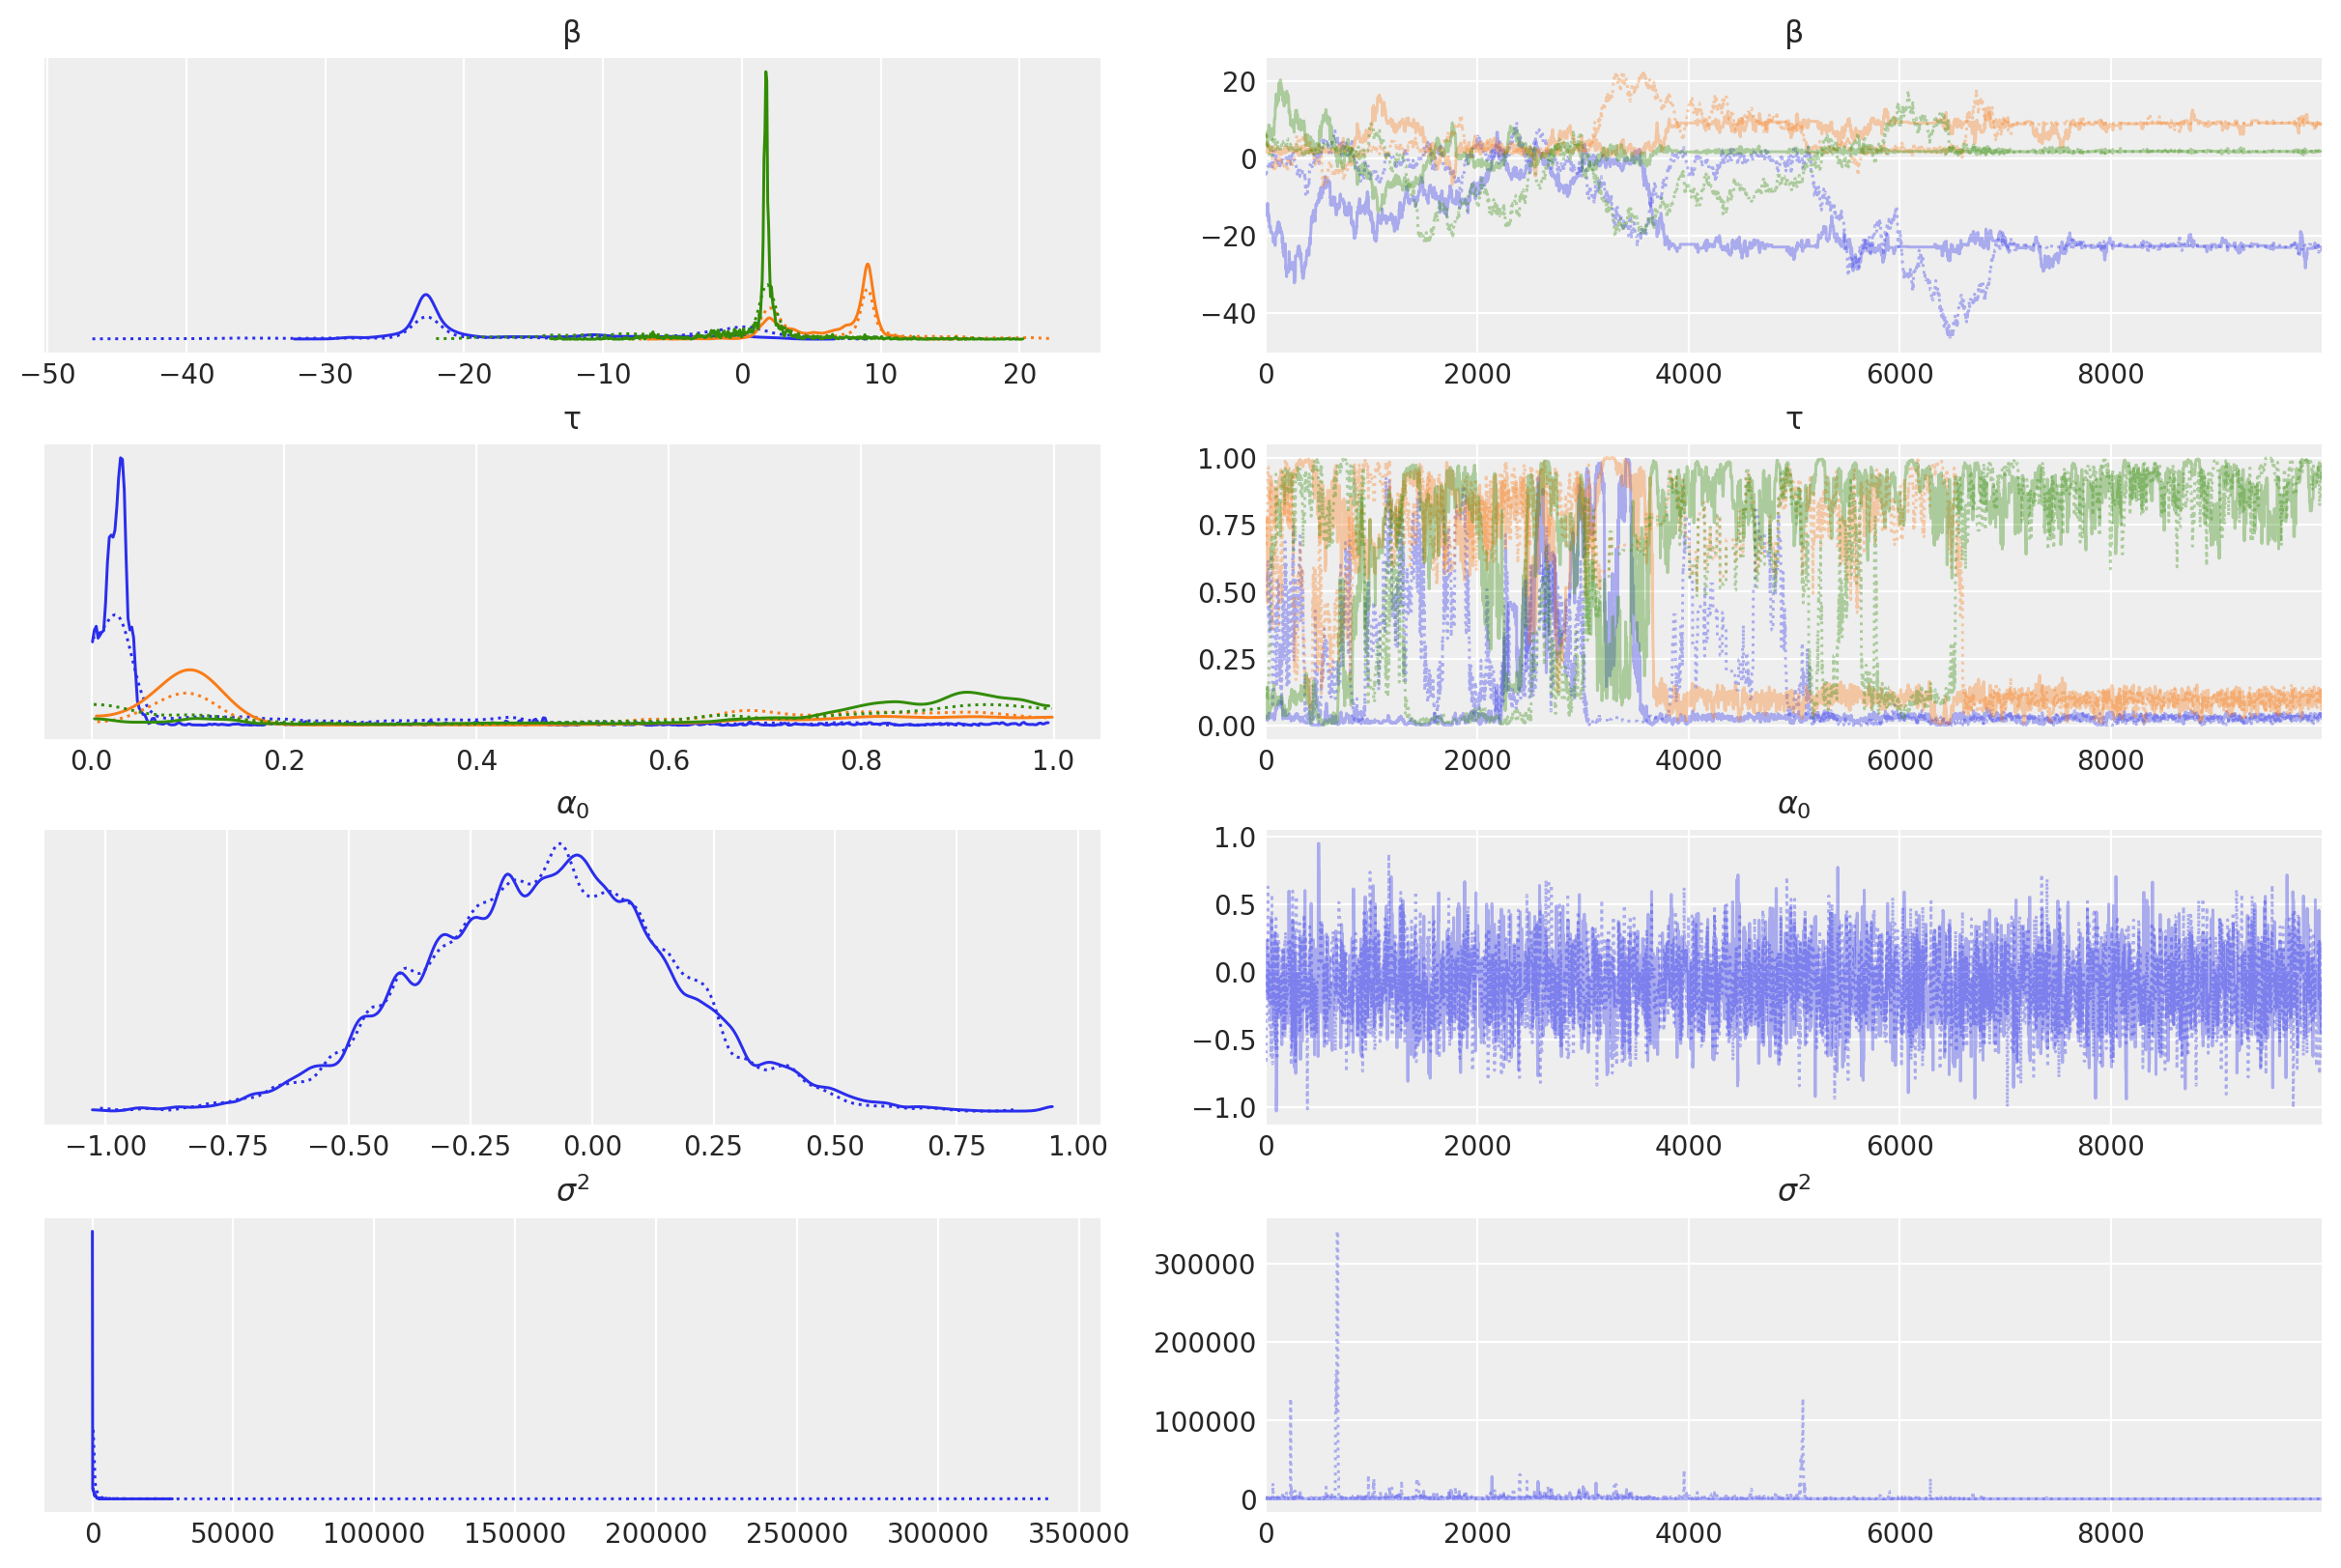

In [33]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


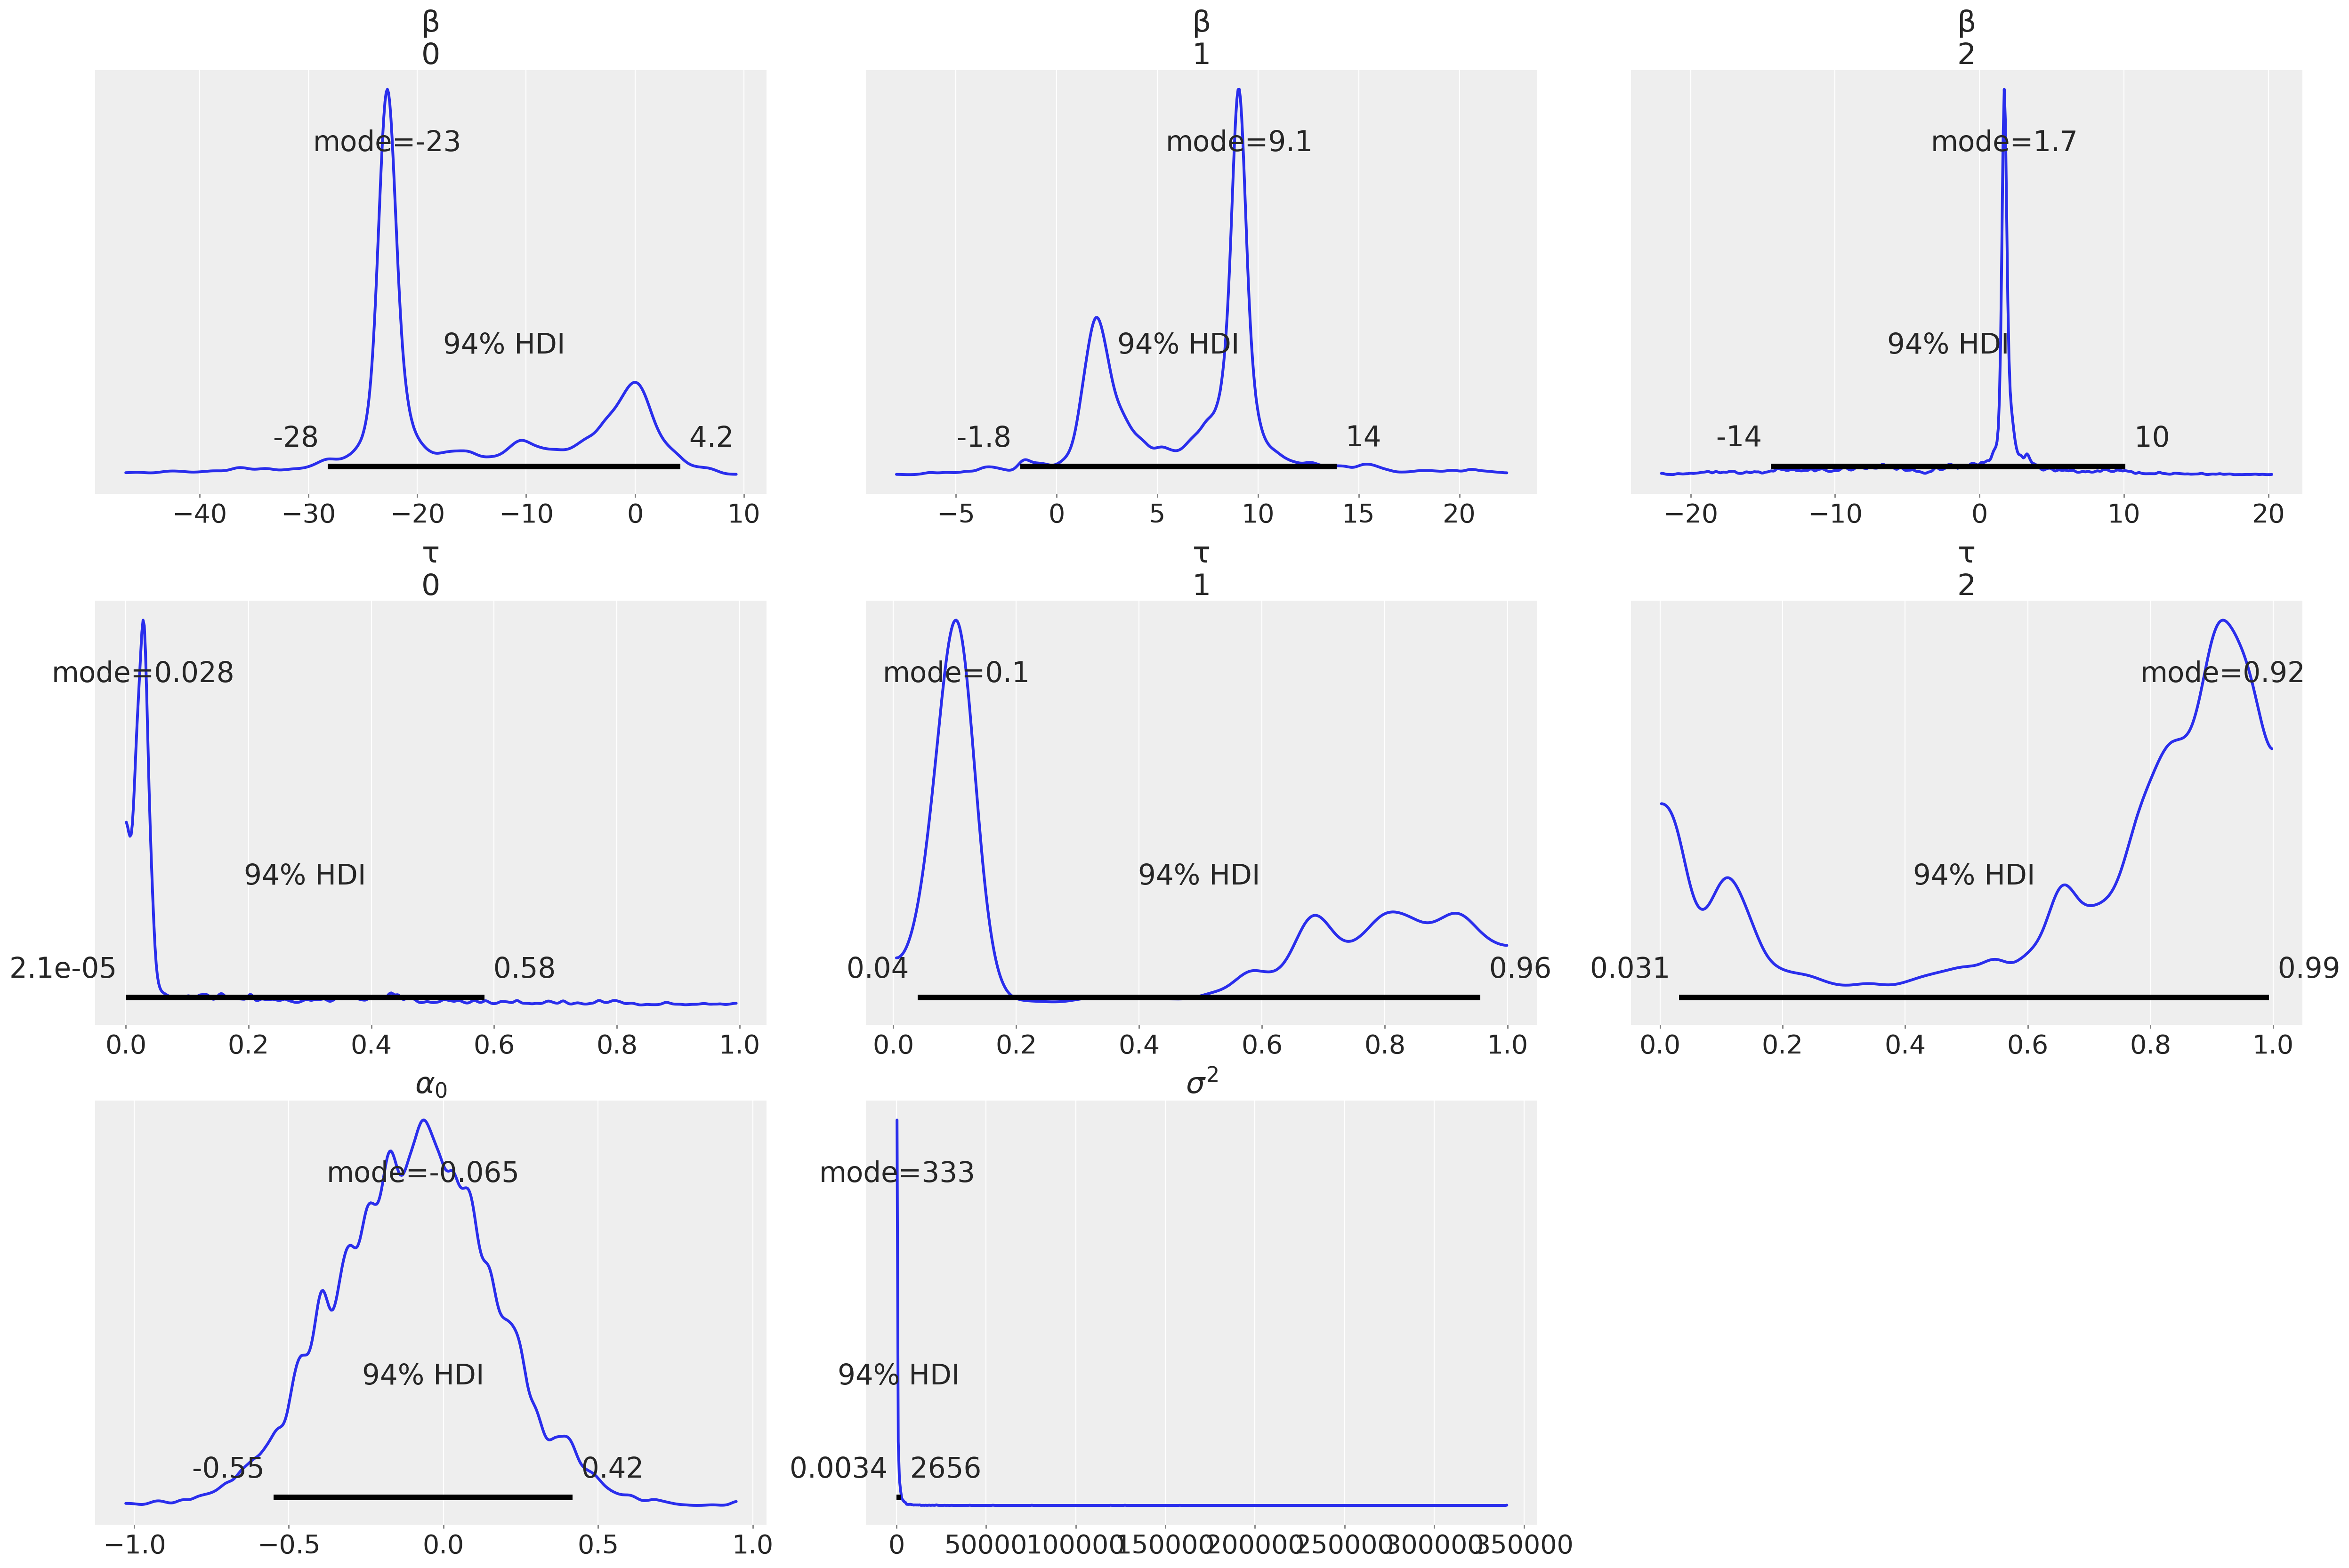

In [34]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.536
bpv [T=mean]: 0.536
bpv [T=std]: 0.853


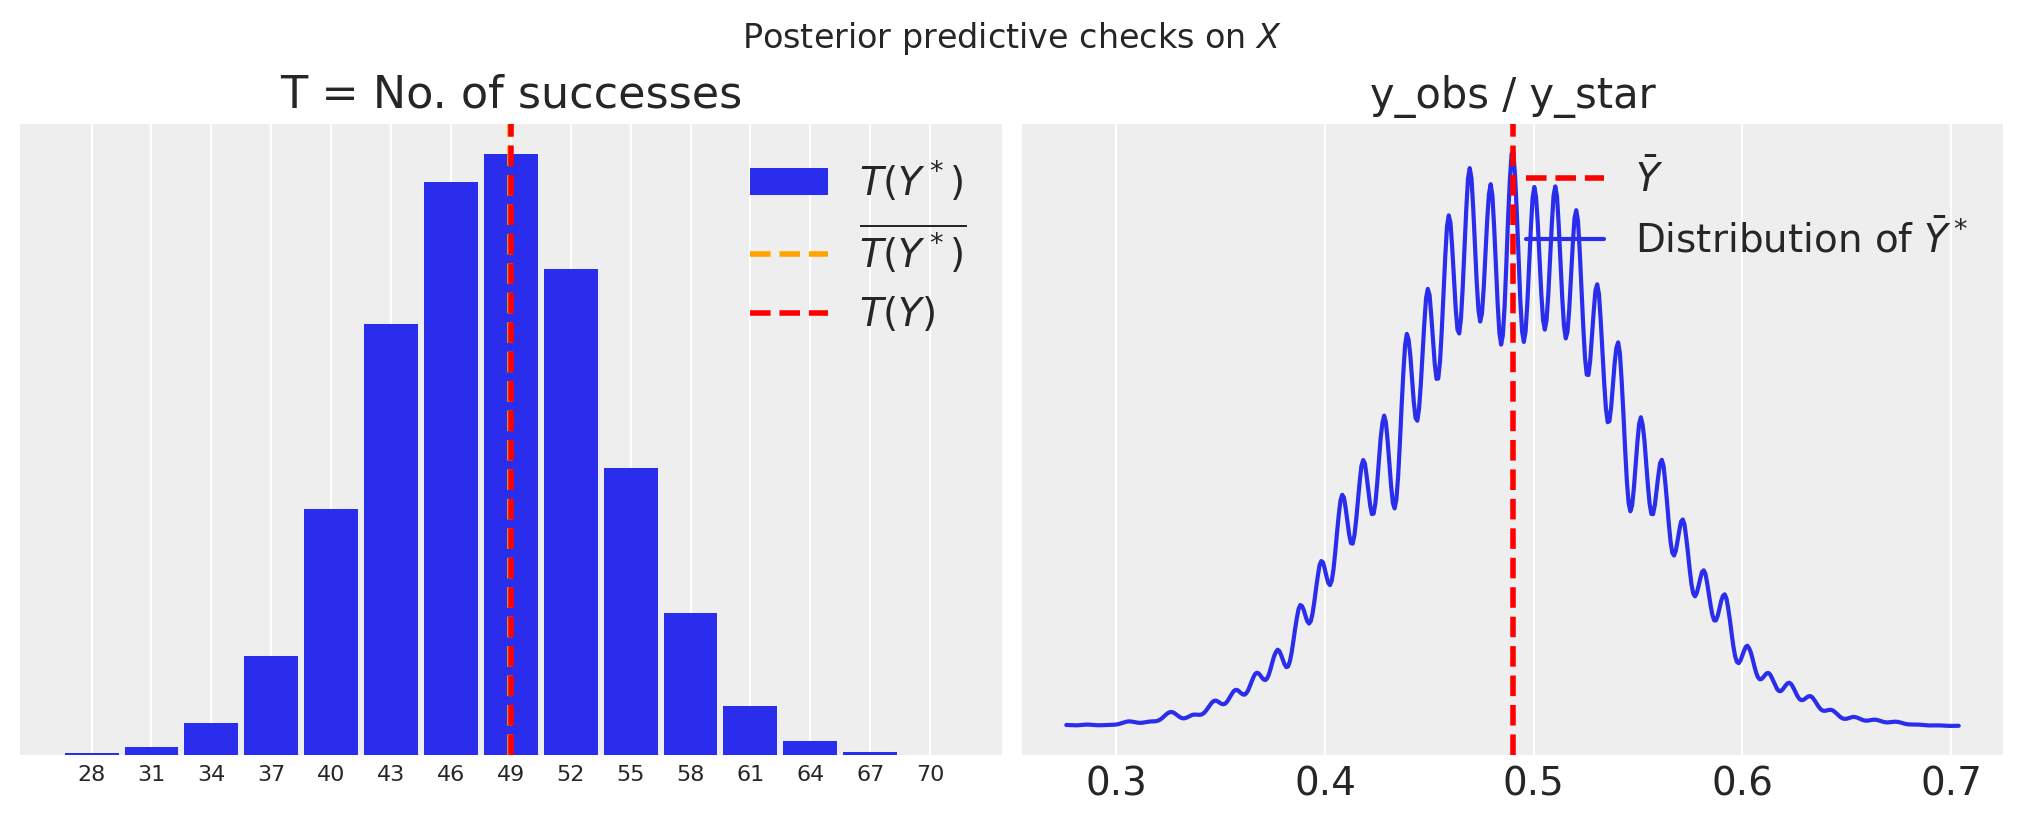

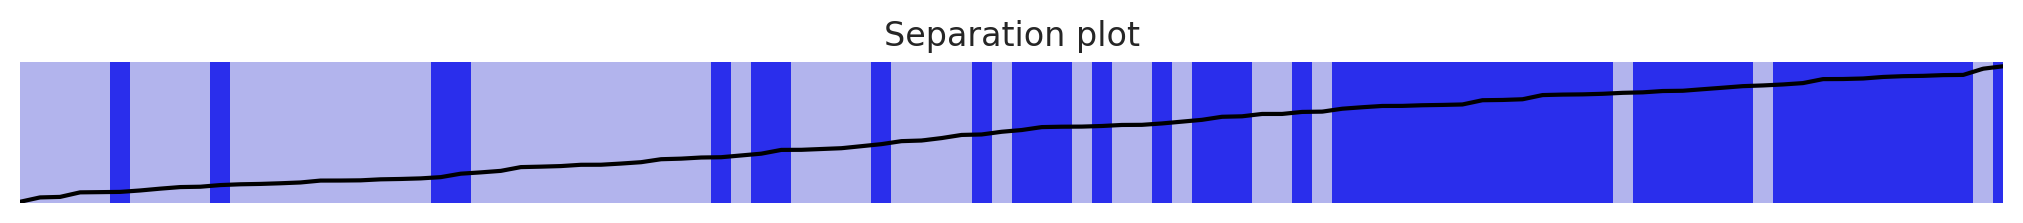

In [35]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    pp_p, pp_y = utils.generate_pp(
        idata_pymc, X, theta_names, rng=rng, kind='classification')
    utils.pp_to_idata([pp_p, pp_y], idata_pymc,
                      ['p_star', 'y_star'], merge=True)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

n_success = pp_y.reshape(-1, len(Y)).sum(axis=1)
az.plot_dist(n_success, label=r"$T(Y^*)$", ax=axs[0])
axs[0].axvline(n_success.mean(), ls="--", color="orange",
               lw=2, label=r"$\overline{T(Y^*)}$")
axs[0].axvline(Y.sum(), ls="--", color="red",
               lw=2, label=r"$T(Y)$")
axs[0].set_title("T = No. of successes")
axs[0].legend()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=8)

az.plot_bpv(idata_pymc, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1], bpv=False,
            data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y.mean(), ls="--", color="r",
               lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)

# Separation plot
az.plot_separation(idata_pymc, y="y_obs", y_hat="p_star", y_hat_line=True,
                   figsize=(10, 1), legend=False)
plt.title("Separation plot", fontsize=12)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


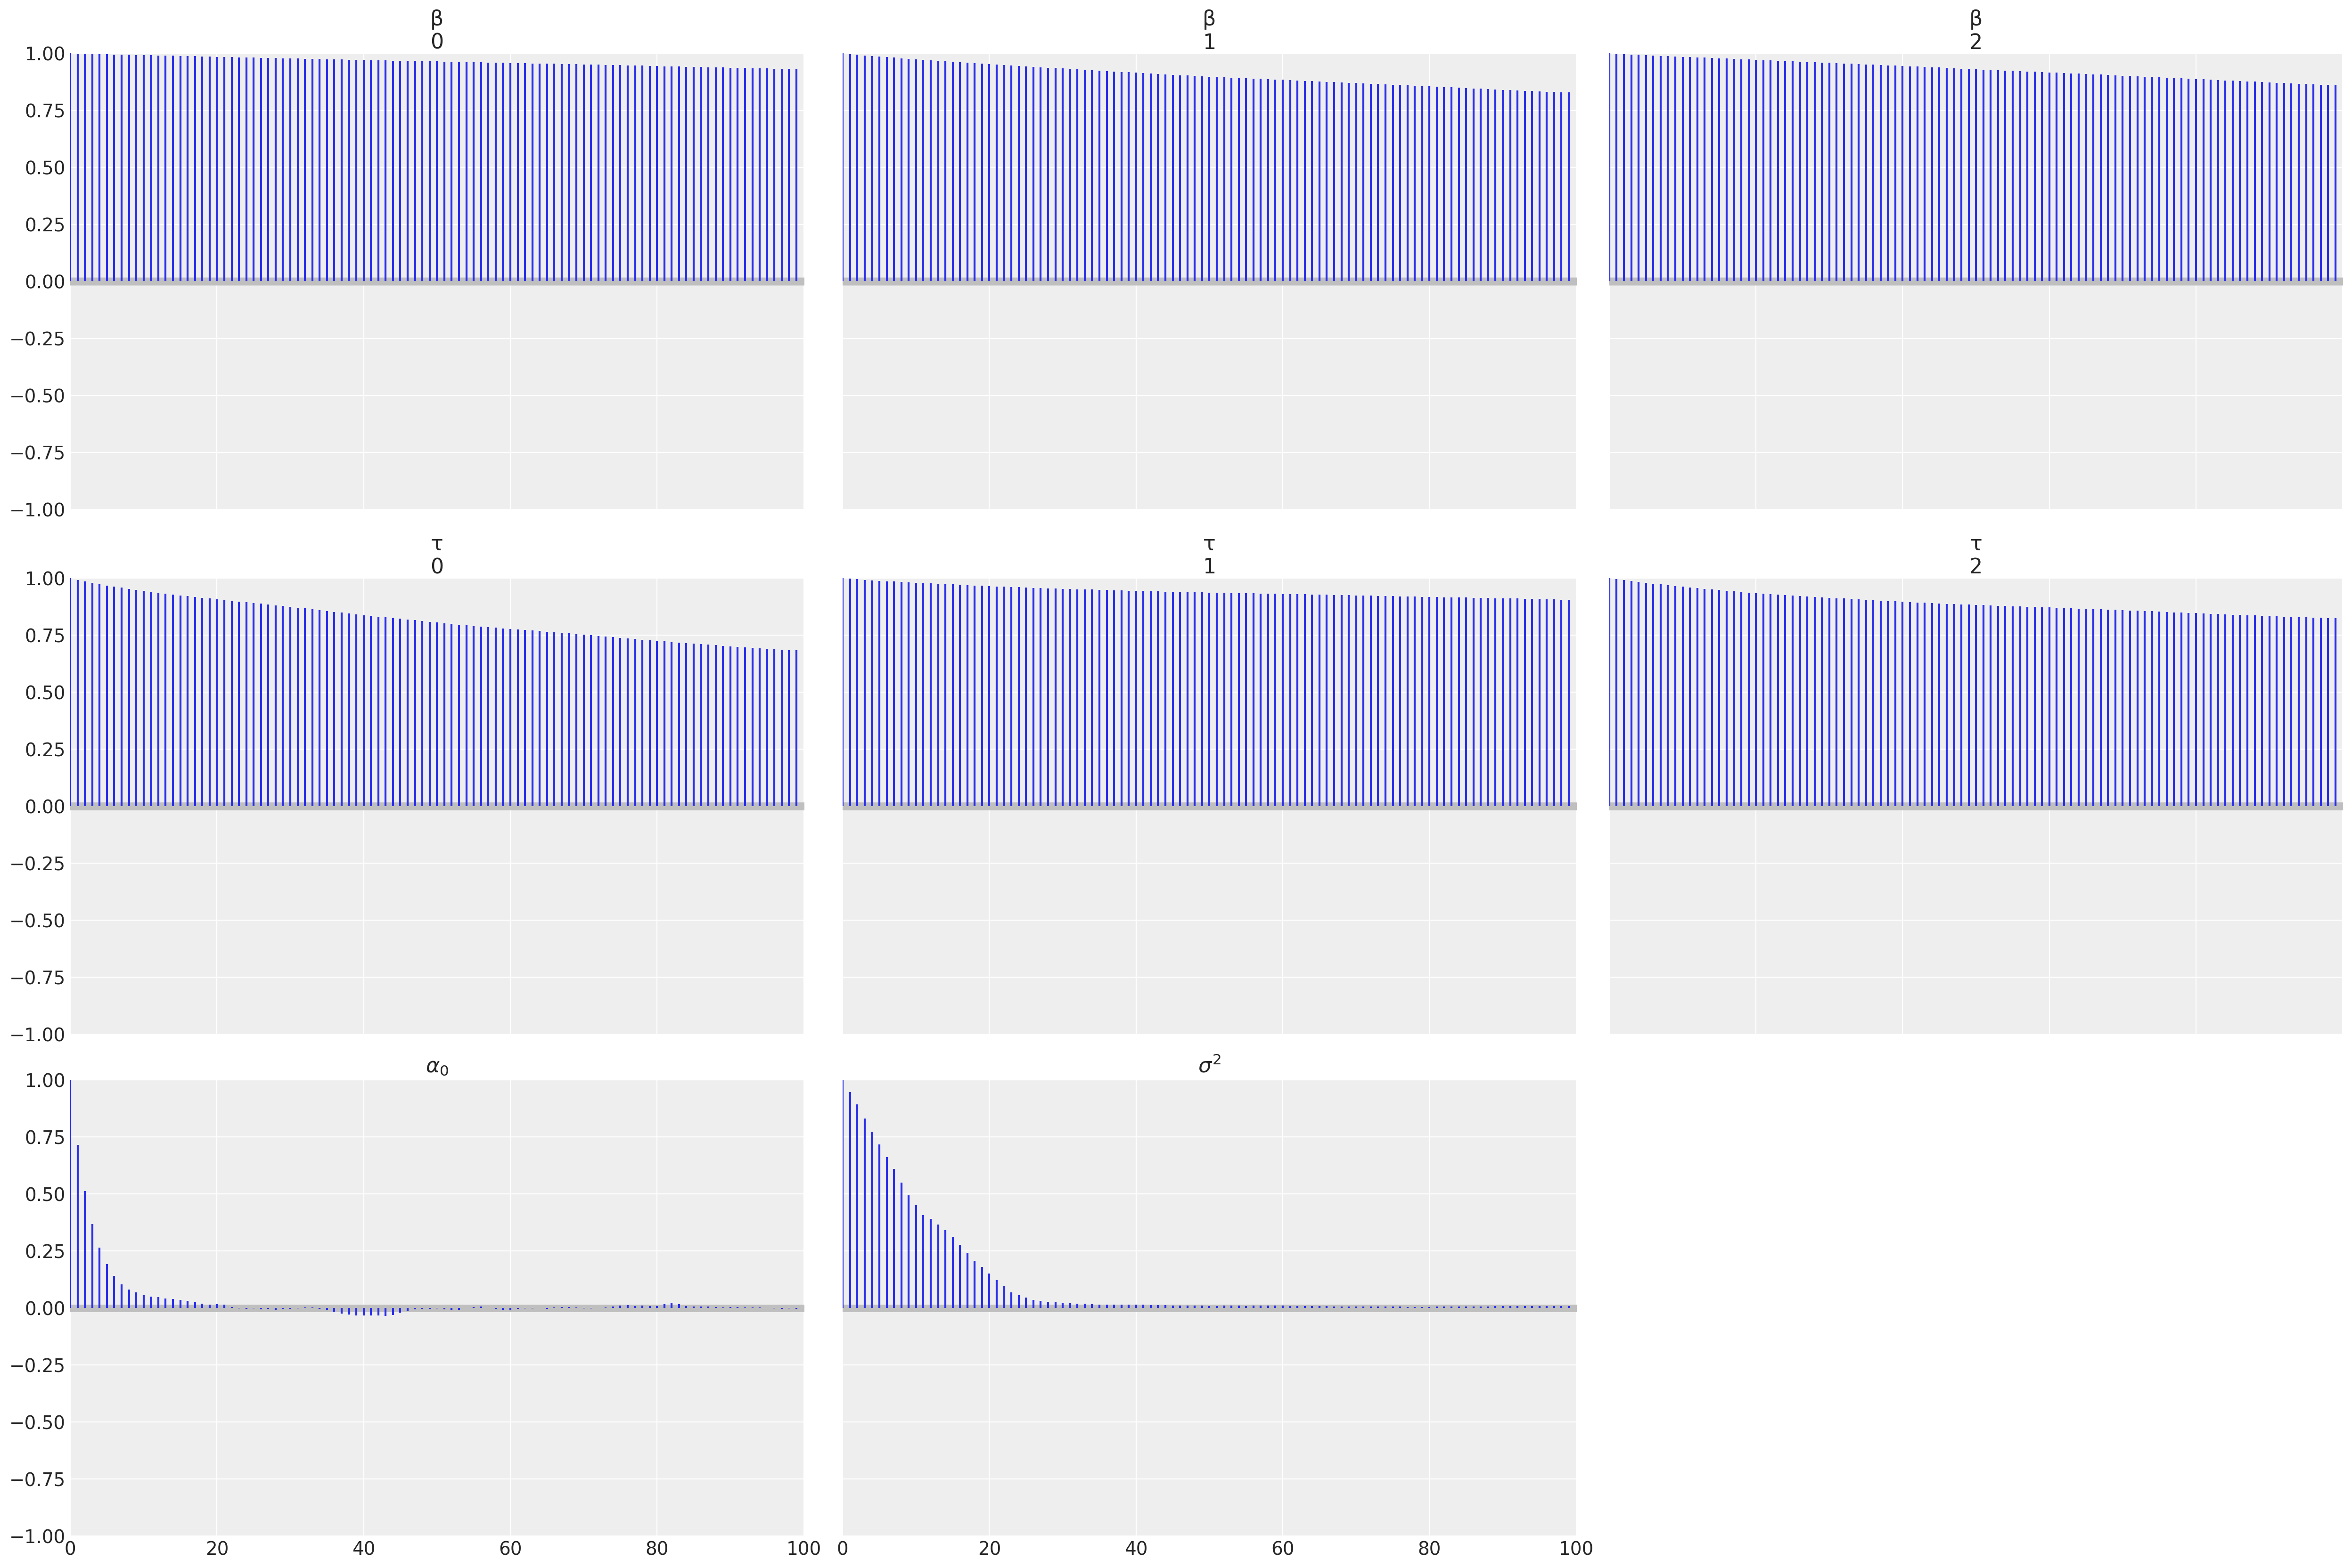

In [36]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

Graphical model:


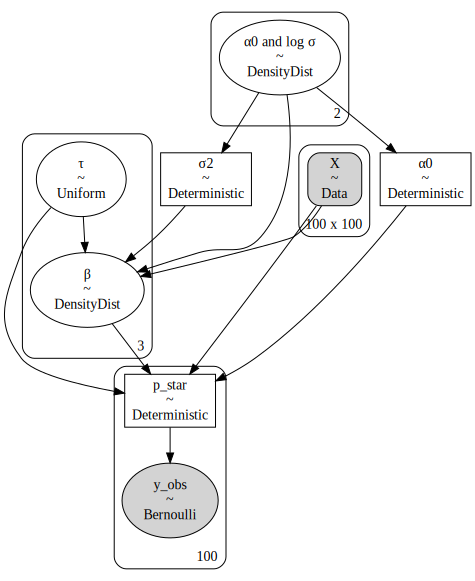

In [39]:
print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.497
bpv [T=mean]: 0.497
bpv [T=std]: 1.000


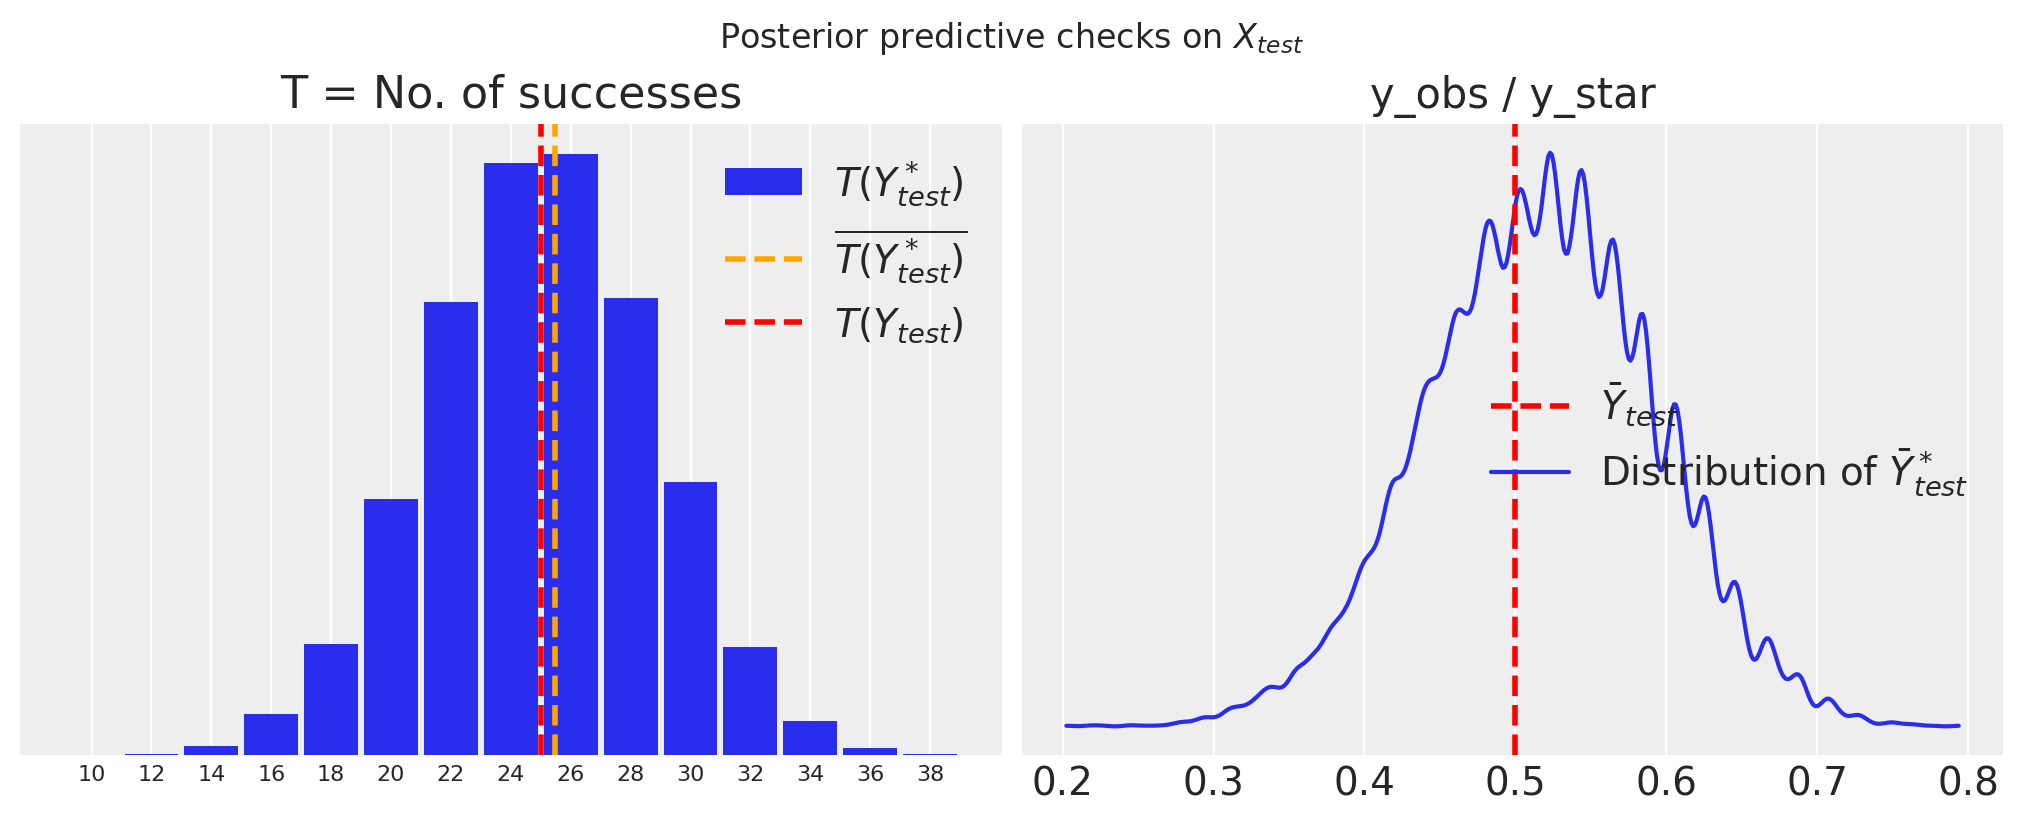

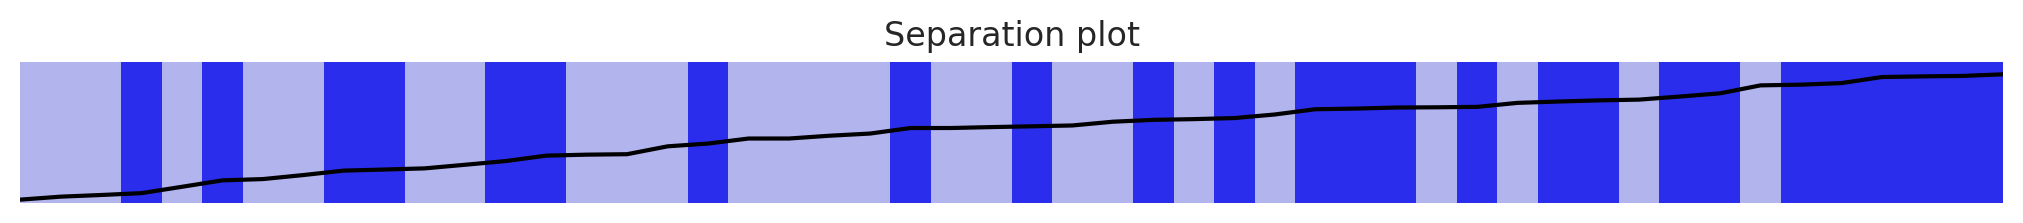

In [37]:
# -- Generate and plot posterior predictive samples from X_test

model_test = make_model(theta_space, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta_tr)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    pp_test_p, pp_test_y = utils.generate_pp(
        idata_pymc, X_test, theta_names, rng=rng, kind='classification')
    idata_pp_test = utils.pp_to_idata(
        [pp_test_p, pp_test_y], idata_pymc,
        ['p_star', 'y_star'], y_obs=Y_test)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

n_success_test = pp_test_y.reshape(-1, len(Y_test)).sum(axis=1)
az.plot_dist(n_success_test, label=r"$T(Y_{test}^*)$", ax=axs[0])
axs[0].axvline(n_success_test.mean(), ls="--", color="orange",
               lw=2, label=r"$\overline{T(Y_{test}^*)}$")
axs[0].axvline(Y_test.sum(), ls="--", color="red",
               lw=2, label=r"$T(Y_{test})$")
axs[0].set_title("T = No. of successes")
axs[0].legend()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=8)

az.plot_bpv(idata_pp_test, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1], bpv=False,
            data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y_test.mean(), ls="--", color="r",
               lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
axs[1].legend(handles=handles)

# Separation plot
az.plot_separation(idata_pp_test, y="y_obs", y_hat="p_star",
                   y_hat_line=True, figsize=(10, 1), legend=False)
plt.title("Separation plot", fontsize=12)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters.

In [38]:
# -- Compute metrics using several point estimates

df_metrics_pymc = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat_pp_mean = [utils.threshold(y)
                 for y in pp_test_p[:, ::thin_pp, :].mean(axis=(0, 1))]
metrics_pp_mean = utils.classification_metrics(Y_test, Y_hat_pp_mean)
Y_hat_pp_vote = [utils.threshold(y)
                 for y in pp_test_y[:, ::thin_pp, :].mean(axis=(0, 1))]
metrics_pp_vote = utils.classification_metrics(Y_test, Y_hat_pp_vote)
df_metrics_pymc.loc[0] = [
    "pymc_posterior_mean",
    p_hat,
    metrics_pp_mean["acc"]
]
df_metrics_pymc.loc[1] = [
    "pymc_posterior_vote",
    p_hat,
    metrics_pp_vote["acc"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat_pe = utils.point_predict(
        X_test, idata_pymc,
        theta_names, pe, kind='classification')
    metrics_pe = utils.classification_metrics(Y_test, Y_hat_pe)
    df_metrics_pymc.loc[i + 2] = [
        "pymc_" + pe,
        p_hat,
        metrics_pe["acc"],
    ]

df_metrics_pymc.sort_values(results_columns[-1], inplace=True, ascending=False)
df_metrics_pymc.style.hide(axis="index")

In [39]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = pd.DataFrame(columns=results_columns)

for pe in point_estimates:
    df_var_sel = bayesian_var_sel(
        idata_pymc, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="pymc",
        point_est=pe)

    df_metrics_pymc_var_sel = df_metrics_pymc_var_sel.append(df_var_sel)

df_metrics_pymc_var_sel.sort_values(
    results_columns[-1], inplace=True, ascending=False)
df_metrics_pymc_var_sel.style.hide(axis="index")

### Save & Load

In [ ]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [ ]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [40]:
%load_ext watermark
%watermark - n - u - v - iv - w

Last updated: Thu Jan 20 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.30.1

autopep8  : 1.6.0
scipy     : 1.7.3
numpy     : 1.20.3
emcee     : 3.1.1
pandas    : 1.3.5
theano    : 1.1.2
pymc3     : 3.11.4
skfda     : 0.0
matplotlib: 3.5.1
sys       : 3.9.9 (main, Jan  3 2022, 14:06:06) 
[GCC 11.1.0]
arviz     : 0.11.4
logging   : 0.5.1.2
json      : 2.0.9

Watermark: 2.2.0

